### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com 


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests
import re

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate


import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Sep 10 2024, 10:57:35) [Clang 17.0.6 ]
LangChain         0.3.3
OpenAI            1.52.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


# Test LLM calling

In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-10-23 06:40:10,001 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_61e551c4c2', 'finish_reason': 'stop', 'logprobs': None}, id='run-1448c504-abc9-4d6a-a514-e9c6b78d1300-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}})

In [5]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-10-23 06:40:10,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
# time multiple templates (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-10-23 06:40:10,722 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-10-23 06:40:11,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-10-23 06:40:13,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres hermosa y te amo.

2024-10-23 06:40:14,108 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei straordinario/a. Sei magnifico/a e ti amo.

2024-10-23 06:40:15,517 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Figyelj rám. Elbűvölő vagy. Lélegzetelállító vagy, és szeretlek.

Elapsed seconds: 6.342670


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-10-23 06:40:17,955 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 06:40:18,045 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 06:40:18,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 06:40:19,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 06:40:19,302 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 2.501711
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.
Hallgass rám. Elbűvölő vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [9]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 3
before_date = None
# before_date = '2024-10-19 15:00:00'
do_download = True


In [10]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: list             #  bullet points for summary email
    summary: str              #  final summary
    cluster_topics: list      #  list of cluster topics
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [11]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)


In [12]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [13]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [14]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [15]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

In [16]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [17]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [18]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [19]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [20]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [21]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [22]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [23]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [24]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    log(f"Proposed categories: {state['cluster_topics']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [25]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [26]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [27]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [28]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [29]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [30]:
# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [31]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [32]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # extract subject, match a top-level Markdown heading (starts with "# ")
    match = re.search(r"^# (.+)$", state["summary"], re.MULTILINE)
    
    # If a match is found, return the first captured group (the heading text)
    if match:
        subject = match.group(1).strip()
    else:
        subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    log(f"Email subject {subject}")
    log(f"Email length {len(html_str)}")
        
    # send email
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_statestate)

# Define LangGraph agent state graph

In [33]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

2024-10-23 06:40:41,871 - AInewsbot - INFO - Initializing with before_date=None, do_download=True, thread_id=b3b05b6dec1048acbb6dc6157d74a48c


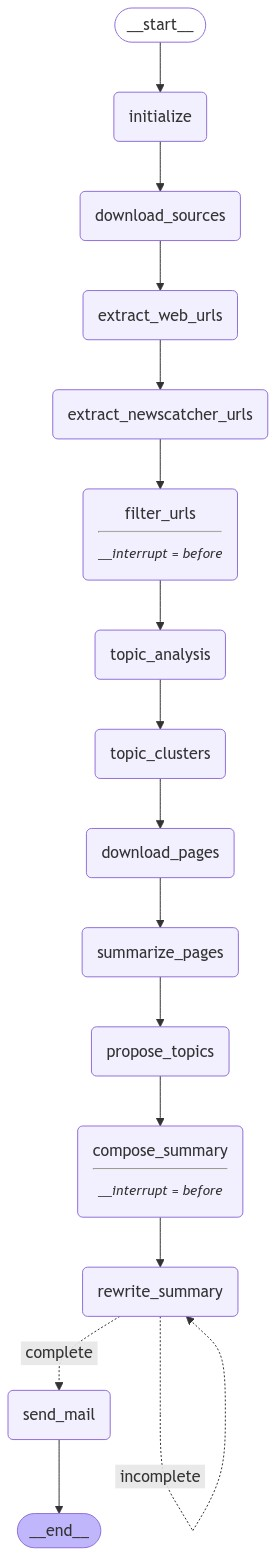

In [34]:
do_download = True
before_date = None
# before_date="2024-10-21 08:00:00"

# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [35]:
# download and extract, check all sources downloaded OK
state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 18 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-10-23 06:40:48,582 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-23 06:40:48,583 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-23 06:40:48,583 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-23 06:40:48,584 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-23 06:40:48,584 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-23 06:40:48,585 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-23 06:40:48,585 - AInewsbot - INFO - 

2024-10-23 06:42:25,016 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
NoSuchElementError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:510:5
dom.find/</<@chrome://remote/content/shared/DOM.sys.mjs:136:16

2024-10-23 06:42:25,017 - AInewsbot - INFO - get_files(Ars Technica) - Saving Ars Technica (10_23_2024 06_42_25 AM).html as utf-8
2024-10-23 06:42:25,018 - AInewsbot - INFO - Processing Hacker News 2
2024-10-23 06:42:25,019 - AInewsbot - INFO - get_files(Hacker News Page 2) - starting get_files https://news.ycombinator.com/?p=2
2024-10-23 06:42:33,981 - AInewsbot - INFO - get_files(Google News - Technology - Artificial intelligence) -

2024-10-23 06:43:07,101 - AInewsbot - INFO - get_files(The Verge AI) - Saving The Verge AI (10_23_2024 06_43_07 AM).html as utf-8
2024-10-23 06:43:07,104 - AInewsbot - INFO - Processing WSJ Tech
2024-10-23 06:43:07,105 - AInewsbot - INFO - get_files(WSJ Technology) - starting get_files https://www.wsj.com/tech/ai
2024-10-23 06:43:08,720 - AInewsbot - INFO - get_files(VentureBeat AI) - Saving VentureBeat AI (10_23_2024 06_43_08 AM).html as UTF-8
2024-10-23 06:43:08,722 - AInewsbot - INFO - Processing WaPo Tech
2024-10-23 06:43:08,722 - AInewsbot - INFO - get_files(Washington Post Technology) - starting get_files https://www.washingtonpost.com/technology/innovations/
2024-10-23 06:43:12,081 - AInewsbot - INFO - get_files(Feedly AI) - Loading additional infinite scroll items
2024-10-23 06:43:16,426 - AInewsbot - INFO - Message: Unable to locate element: //meta[@http-equiv='Content-Type']; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troub

2024-10-23 06:43:45,383 - AInewsbot - INFO - parse_file - found 169 raw links
2024-10-23 06:43:45,384 - AInewsbot - INFO - parse_file - found 68 filtered links
2024-10-23 06:43:45,385 - AInewsbot - INFO - 68 links found
2024-10-23 06:43:45,385 - AInewsbot - INFO - Hacker News -> htmldata/Hacker News Page 1 (10_23_2024 06_42_34 AM).html
2024-10-23 06:43:45,395 - AInewsbot - INFO - parse_file - found 256 raw links
2024-10-23 06:43:45,398 - AInewsbot - INFO - parse_file - found 29 filtered links
2024-10-23 06:43:45,398 - AInewsbot - INFO - 29 links found
2024-10-23 06:43:45,398 - AInewsbot - INFO - Hacker News 2 -> htmldata/Hacker News Page 2 (10_23_2024 06_42_35 AM).html
2024-10-23 06:43:45,410 - AInewsbot - INFO - parse_file - found 261 raw links
2024-10-23 06:43:45,412 - AInewsbot - INFO - parse_file - found 22 filtered links
2024-10-23 06:43:45,412 - AInewsbot - INFO - 22 links found
2024-10-23 06:43:45,413 - AInewsbot - INFO - HackerNoon -> htmldata/HackerNoon (10_23_2024 06_42_45 AM

18


,id
src,
Ars Technica,26
Bloomberg Tech,11
Business Insider,49
FT Tech,62
Feedly AI,57
Google News,65
Hacker News,28
Hacker News 2,22
HackerNoon,102


In [36]:
state = lg_agent.filter_urls(state)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-10-23 06:43:46,265 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-10-23 06:43:46,931 - AInewsbot - INFO - URLs in orig_df: 963
2024-10-23 06:43:46,933 - AInewsbot - INFO - Existing URLs in DB: 167607
2024-10-23 06:43:46,969 - AInewsbot - INFO - New URLs in df filtered by URL: 244
2024-10-23 06:43:47,062 - AInewsbot - INFO - Existing src+title: 14
2024-10-23 06:43:47,062 - AInewsbot - INFO - New URLs in df filtered by src+title: 230
2024-10-23 06:43:47,073 - AInewsbot - INFO - Found 223 unique new headlines
2024-10-23 06:43:47,252 - AInewsbot - INFO - Applying prompt to 5 pages using gpt-4o-mini
2024-10-23 06:43:47,253 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:43:47,254 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:43:47,254 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:43:47,255 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:43:47,255 - AInewsbot - INFO - sent 23 items 
2024-10-23 06:43:49,164 - AInewsbot - INFO - got dict with 23 items 
2024-10-2

,id
src,
Business Insider,3
Feedly AI,37
Google News,15
HackerNoon,4
NYT Tech,1
Newscatcher,17
Techmeme,1
The Register,2
The Verge,3


In [37]:
for row in pd.DataFrame(state["AIdf"]).itertuples():
    display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


[0. 'New AI update to lock phones will deter thieves' - Feedly AI](https://www.bbc.com/news/articles/c1484r0r3m6o)

[1. ABBA, Radiohead and The Cure musicians sign AI protest letter against 'unlicensed use' of works - Newscatcher](https://www.washingtonpost.com/business/2024/10/22/generative-ai-abba-radiohead-thom-yorke/762d15c0-90b9-11ef-b5b1-75167840d9f3_story.html)

[2. ABBA, Radiohead and The Cure musicians sign AI protest letter against unlicensed use' of works - Newscatcher](https://thehill.com/homenews/ap/ap-business/ap-abba-radiohead-and-the-cure-musicians-sign-ai-protest-letter-against-unlicensed-use-of-works-2)

[3. AI Is Making It Easier for Scammers to Steal Homes From Their Owners - Google News](https://news.google.com/read/CBMimAFBVV95cUxPYjBjY3dITXdtWDRaU29Xemc2aTktRHRJMnlDbm96d0JvVzVRQjh4U1ZrZjB2R2ZwbkI0OFBmMHlMenduZkVKWHZiRUF6UUNHSF9DU2dQTGpReDNfX2FiVG02bnh0aGVDemVrMTNmY0xJZ21VU1plOFl3dW8ybHZRdWxtQUdOT19lWXAwd295SjlTWFY5c1pZcw)

[4. AI at work: Will it contribute to employee burnout? - Feedly AI](https://www.bbc.co.uk/news/articles/c93pz1dz2kxo)

[5. AI firms and civil society groups plead for passage of federal AI law ASAP - Feedly AI](https://go.theregister.com/feed/www.theregister.com/2024/10/23/ai_firms_and_civil_society/)

[6. AI firms and civil society groups plead for passage of federal AI law ASAPCongress urged to act before year's end to support US competitivenessAI + ML4 hrs|3 - The Register](https://www.theregister.com/2024/10/23/ai_firms_and_civil_society/)

[7. AI firms need to address security, open-source concerns: G42 exec - Newscatcher](https://www.yahoo.com/news/ai-firms-address-security-open-224302375.html)

[8. AI sparks backlash from ABBA, Radiohead, and The Curethousands of artists sign letter protesting the use of their work to train robots - Google News](https://news.google.com/read/CBMioAFBVV95cUxOUFVnV3E3bTlQLVB5Y1VSekREaDNHU0FlcGxDcUV5QUhGRmpUX1psZnRUU2ZpU2xtVXkxYTVlS1F1U3I3NGVWT1hNU18zd1FEaFp1bm9KNWlXWFdlMDBfc0t5MHktWTZYaUJiVk1JT3BsYVJOMW1TNDdPRE5ZZGZTUlpZLXBjbVNUd0NFaWxiamRjdWlDOFFZVTdTMG1VUjJa)

[9. A leaked internal report claims Apple Intelligence could be two years behind OpenAI's ChatGPT but its hard to count the iPhone maker out of the AI race: By 2026, nearly every Apple device with a screen will run it" - Feedly AI](https://www.windowscentral.com/software-apps/apple-intelligence-could-already-be-behind-chatgpt)

[10. Amazon's AI data center dream runs into the reality of 'zombie' facilities, higher costs, and labor shortages - Business Insider](https://www.businessinsider.com/amazon-data-centers-delays-costs-power-labor-shortages-aws-ai-2024-10)

[11. Amazon-backed Anthropic debuts AI agents that can do complex tasks, racing against OpenAI, Microsoft and Google - Feedly AI](https://www.cnbc.com/2024/10/22/anthropic-announces-ai-agents-for-complex-tasks-racing-openai.html)

[12. An interview with Craig Federighi on the launch of Apple Intelligence features like notification summaries in iOS 18.1, Siri, Apple's AI strategy, and more - Techmeme](https://www.wsj.com/tech/personal-tech/apple-intelligence-3833c320)

[13. Anthropic publicly releases AI tool that can take over the users mouse cursor - Google News](https://news.google.com/read/CBMiswFBVV95cUxPRkJrVGhSWDZPV0psaEQtNTJndFczQnJzOWR6TGNSSFdRWmR1U3Nfd0ZSd3pGTHoxOHVldVdLSmVnekU0bUw1VEVBTkJMWUY0eHRiN29ldUVYUHNHS2JHTU5CTWxPeHhYcjRzbEtCNHZteHJRS1lwZHROZTNYZ3ktRFpuTnd2V2Y0MU1TQkU1WThnRFY4cThYSnd4R3lUanh5TENaTE9VdWFiT0VTTWc4eFExMA)

[14. Anthropics latest AI update can use a computer on its own - The Verge](https://www.theverge.com/2024/10/22/24276822/anthopic-claude-3-5-sonnet-computer-use-ai)

[15. Anthropics new AI can use computers like a human, redefining automation for enterprises - Google News](https://news.google.com/read/CBMiswFBVV95cUxPR3VUbWZYc0NqREdvc1lRQzZLd29NcjhueHVBRjNSSGRwZlQ0eE9ydnRveElSWVhqakJzbEI4bndmc2ZTNTBHVy1qUDZ2VDVpUUJLQjR0MnAyRlJQVk5zd3dsVDFhMDFxZ01yQTYzaUZWQTlab1lFc2F3OUtsWmZKOEVlX3M1Z2IxT1Z5bllzSUdqeXBTOGNOVjhBS3FDM04tdWlIcF9xdGlMNXJqa0lRYVJFaw)

[16. Apple's Software Chief Explains AI Delays, Future of Siri and More - WSJ Tech](https://www.wsj.com/video/series/joanna-stern-personal-technology/apple-software-chief-explains-ai-delays-future-of-siri-and-more/7F3883B2-0404-4618-97EE-5ABA1AC1602C)

[17. Apple's Tim Cook meets China regulator in Beijing but no final word on Apple Intelligence - Newscatcher](https://www.scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)

[18. Apple's Tim Cook meets Chinese regulators but no final word on AI roll-out - Newscatcher](https://scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)

[19. Apple Intelligence Isnt Very Smart Yetand Apples OK With That - Google News](https://news.google.com/read/CBMidEFVX3lxTFBQSXpoVTRBOG9iNVd5d0lKb0lGZ1RwQkpkY0NtNDEwXzhvdW56dWR6TDBRT3QyVmdSd3hhUzNKYndOMm1vUkhtYUVEMV9NNkE0aUZhT3NNbmpHWTA3bGdzSEp6UlpJYWROY0RiWlhIdFllZVVy)

[20. Apple is concerned about AI turning real photos into fantasy - The Verge](https://www.theverge.com/2024/10/23/24277489/apple-intelligence-iphone-ai-photo-editing-craig-federighi-interview)

[21. Apples Craig Federighi Explains Apple Intelligence Delays, Siris Future and More | WSJ - Google News](https://news.google.com/read/CCAiC2ZyOEFMY0VpWUFrmAEB)

[22. Applying AI to satellite manufacturing - Google News](https://news.google.com/read/CBMibkFVX3lxTE5sSnh5WEhVNVRpX3c1Q3lDdGR4cERsT2ZHOWZUVmlhUmduUm1nRFFadUs2bHpKYVBTbnlseWFsU2JYQXN5ZzdZZThpdXVsVkRKaGFUVlUyOWgtM3FGaW83TWhHR18wS3doMG4zVGRB)

[23. Aptos Orbital Announces Official Launch of Powerful AI Satellite Platform - Newscatcher](https://finance.yahoo.com/news/aptos-orbital-announces-official-launch-130100791.html)

[24. Artificial Minds, Human Consequences: Explaining AIs Impact on Our Education, Cognition, and More - HackerNoon](https://hackernoon.com/artificial-minds-human-consequences-explaining-ais-impact-on-our-education-cognition-and-more)

[25. As AI Hits E-Discovery, Lawyers Go From Big Law to Boutique - Feedly AI](https://news.bloomberglaw.com/us-law-week/as-ai-hits-e-discovery-lawyers-go-from-big-law-to-boutique)

[26. BlackRock Expands AI and Tech Investment Opportunities with New Active ETFs - Newscatcher](https://uk.finance.yahoo.com/news/blackrock-expands-ai-tech-investment-213831075.html)

[27. Can A.I. Be Blamed for a Teens Suicide? - NYT Tech](https://www.nytimes.com/2024/10/23/technology/characterai-lawsuit-teen-suicide.html)

[28. Character.ai Faces Lawsuit After Teens Suicide - Google News](https://news.google.com/read/CBMiiwFBVV95cUxQbGtQZjJ3TWlnS1dvZHhjcWtVZENCZUl0Z0QtdTE0NG5yeTB5cjU4UFVLTjVXQUpMNFQxcW51OVAxc3ItWGIzZTNQbGNxTHhwNW11RDRnUkRITXdsQnNnSGF5MTNyOG5ublJrcnBTZGFuWmZBdTY4eUR4MlI1aG03N3VQTTZGVHpUUlBj)

[29. Craig Federighi Explains Phased Release of Apple Intelligence Features - Feedly AI](https://www.macrumors.com/2024/10/23/craig-federighi-phased-release-apple-intelligence/)

[30. Craig Federighi says Siri won't become sentient, but it'll get better - Newscatcher](https://appleinsider.com/articles/24/10/23/craig-federighi-says-siri-wont-become-sentient-but-itll-get-better)

[31. Dawn of the Agent: New Claude AI can take over your computer - Feedly AI](https://newatlas.com/ai-humanoids/anthropic-claude-computer-use-agent-ai/)

[32. Discrete Diffusion with Planned Denoising (DDPD): A Novel Machine Learning Framework that Decomposes the Discrete Generation Process into Planning and Denoising - Feedly AI](https://www.marktechpost.com/2024/10/22/discrete-diffusion-with-planned-denoising-ddpd-a-novel-machine-learning-framework-that-decomposes-the-discrete-generation-process-into-planning-and-denoising/)

[33. Dont be fooled by AI companies ethics washing - Feedly AI](https://www.fastcompany.com/91214394/dont-be-fooled-by-ai-companies-ethics-washing)

[34. Exclusive: Legal tech startup Genie AI just raised $17.8 million from Google and Khosla Ventures using this 13-slide deck - Business Insider](https://www.businessinsider.com/genie-ai-funding-khosla-ventures-google-pitch-deck-2024-10)

[35. Exploring the mechanism of sustained consumer trust in AI chatbots after service failures: a perspective based on attribution and CASA theories - Feedly AI](https://www.nature.com/articles/s41599-024-03879-5)

[36. Foreign adversaries using artificial intelligence to meddle in U.S. election, FBI says - Newscatcher](https://www.yahoo.com/news/foreign-adversaries-using-artificial-intelligence-010043303.html)

[37. Fujitsu delivers GPU optimization tech it touts as a server-saverMiddleware aimed at softening the shortage of AI acceleratorsAI + ML9 hrs| - The Register](https://www.theregister.com/2024/10/23/fujitsu_gpu_middleware/)

[38. Full Interview: Apples Software Chief Craig Federighi on Future of iPhone AI - WSJ Tech](https://www.wsj.com/video/series/joanna-stern-personal-technology/full-interview-apples-software-chief-craig-federighi-on-future-of-iphone-ai/756B8727-5FFB-422C-AE63-C4600272BD94)

[39. Generative Reward Models (GenRM): A Hybrid Approach to Reinforcement Learning from Human and AI Feedback, Solving Task Generalization and Feedback Collection Challenges - Feedly AI](https://www.marktechpost.com/2024/10/22/generative-reward-models-genrm-a-hybrid-approach-to-reinforcement-learning-from-human-and-ai-feedback-solving-task-generalization-and-feedback-collection-challenges/)

[40. Germany races to catch up inartificial intelligence - Feedly AI](https://dw.com/p/4m7Iv)

[41. Google Chat getting AI-powered summaries via Gemini integration - Newscatcher](https://www.androidheadlines.com/2024/10/google-chat-getting-ai-powered-summaries-via-gemini-integration.html)

[42. HR Leaders Say AI Is The Future  But Someone Forgot To Tell The Employees - Feedly AI](https://allwork.space/2024/10/hr-leaders-say-ai-is-the-future-but-someone-forgot-to-tell-the-employees/)

[43. Heres how Philips Hue could work AI into its lighting scenes - Feedly AI](https://www.techhive.com/article/2495998/heres-how-philips-hue-could-work-ai-into-its-lighting-scenes.html)

[44. How advances in AI and autonomous systems, new tech, and lower costs are shifting global wars towards "precise mass", or the mass deployment of uncrewed systems (Michael C. Horowitz/Foreign Affairs) - Feedly AI](https://www.foreignaffairs.com/world/battles-precise-mass-technology-war-horowitz)

[45. How a worm could save humanity from bad AI - Feedly AI](https://www.ted.com/talks/ramin_hasani_how_a_worm_could_save_humanity_from_bad_ai)

[46. Huawei's latest AI processors were allegedly made by TSMC: Report - Feedly AI](https://www.tomshardware.com/tech-industry/artificial-intelligence/huaweis-latest-ai-processors-were-allegedly-made-by-tsmc-report)

[47. IBM Launches Guardium Data Security Center to Address AI, Quantum, and Hybrid Cloud Risks - Newscatcher](https://ca.finance.yahoo.com/news/ibm-launches-guardium-data-security-205525234.html)

[48. IBM just launched powerful new open source AI models  heres what you need to know - Feedly AI](https://www.itpro.com/technology/artificial-intelligence/ibm-just-launched-powerful-new-open-source-ai-models-heres-what-you-need-to-know)

[49. It's Now Illegal to Post Fake AI-Generated Product Reviews by People Who Don't Exist - Feedly AI](https://futurism.com/the-byte/illegal-fake-reviews-ai)

[50. Joseph Gordon-Levitt criticizes AI, calling Hollywood a "canary in the coal mine" for other industries, and says studios "own the IP and I don't own any of it" (Erich Schwartzel/Wall Street Journal) - Feedly AI](https://www.wsj.com/tech/ai/meet-hollywoods-ai-doomsayer-joseph-gordon-levitt-27b82d69)

[51. Kevin Bacon, Kate McKinnon, and other creatives warn of unjust AI threat - The Verge](https://www.theverge.com/2024/10/22/24276994/ai-statement-training-data-copyright-threat-actors-authors-musicians-kevin-bacon-kate-mckinnon)

[52. Key Roles in a Fraud Prediction project with Machine Learning - Feedly AI](https://towardsdatascience.com/key-roles-in-a-fraud-prediction-project-with-machine-learning-565a01c98274)

[53. ML Metamorphosis: Chaining ML Models for Optimized Results - Feedly AI](https://towardsdatascience.com/ml-metamorphosis-chaining-ml-models-for-optimized-results-d89d952627a9)

[54. Meet Quatfit, The AI Innovator in HackerNoons Startups of the Year Awards! - HackerNoon](https://hackernoon.com/meet-quatfit-the-ai-innovator-in-hackernoons-startups-of-the-year-awards)

[55. Meta AI tackles maths problems that stumped humans for over a century - Google News](https://news.google.com/read/CBMitgFBVV95cUxPQV9iTERJLVBzelpVYnhyM0JPVnVVV1RBaVhxUTdRbGhSMzNnMHpURVZNOE1rdXZ2d3pFNXlLY1A3U0dlZ1ZpemgxclcwNVdiT2pNWldOT1hFRHZ6VGdqZTJxbkRHM3F5dE56VkpuZzNqRHdpZTdZX2pjcml6UUVWWEdnZGc4aW5IWnd0d09tRlJxWU0xRFRwV3ZhcE1uczlwWTBBSUI3VXFEaHVCZU9TX1B4bU9hQQ)

[56. Microsoft lets you create AI agents' using upgraded Copilot Studio - Newscatcher](https://www.androidheadlines.com/2024/10/microsoft-lets-you-create-ai-agents-using-upgraded-copilot-studio.html)

[57. Microsoft ups finance automation game with AI agents - Feedly AI](https://www.cfodive.com/news/microsoft-expands-finance-automation-portfolio-ai-agents/730492/)

[58. Minerals Technologies Announces Deployment of Artificial Intelligence Technology for Mining - Newscatcher](https://finance.yahoo.com/news/minerals-technologies-announces-deployment-artificial-210100061.html)

[59. Moonshine: A Fast, Accurate, and Lightweight Speech-to-Text Models for Transcription and Voice Command Processing on Edge Devices - Feedly AI](https://www.marktechpost.com/2024/10/23/moonshine-a-fast-accurate-and-lightweight-speech-to-text-models-for-transcription-and-voice-command-processing-on-edge-devices/)

[60. More than 10,500 actors, musicians and authors protest techs AI data grab - Google News](https://news.google.com/read/CBMijAFBVV95cUxPZlRUeGdSWXFpbVl5bldJTWZUV3FFbFdQRDRDenFWTHpZV1lFemJla0xnQUlhYWFzUDd4UksyYm5DRm9JWVFXc01mQmx0MjJqY08teHBZQlQzSXdXd282TS1QcHBaMkVRQ01vNHF0eWRaLVNHdFVJTGJ5NHRpWUM0WlN1YlJJR2xTS3d4Ng)

[61. NYC-based Tennr, which uses AI-based document parsing and workflow automation to reduce waiting times for patients, raised a $37M Series B led by Lightspeed (Mike Wheatley/SiliconANGLE) - Feedly AI](https://siliconangle.com/2024/10/22/ai-startup-tennr-raises-37m-automate-healthcare-document-processing/)

[62. New AI tech helps police track suspects' cars without license plate numbers - Feedly AI](https://www.foxnews.com/video/6363607217112)

[63. New York Post, WSJ File Lawsuit Against Perplexity AI Over Author Rights - Feedly AI](https://greekreporter.com/2024/10/23/new-york-post-wsj-sue-perplexity-ai/)

[64. OpenAI's rapid growth loaded with 'corner case' challenges, says Fivetran CEO - Feedly AI](https://go.theregister.com/feed/www.theregister.com/2024/10/23/fivetran_ceo_interview/)

[65. OpenAI Appoints First Chief Economist to Lead AI Economic Research - Newscatcher](https://uk.finance.yahoo.com/news/openai-appoints-first-chief-economist-205520213.html)

[66. OpenAI and Microsoft are funding $10 million in grants for AI-powered journalism - Feedly AI](https://www.engadget.com/ai/openai-and-microsoft-are-funding-10-million-in-grants-for-ai-powered-journalism-193042213.html)

[67. OpenAI appoints ex-Uber exec as chief compliance officer - Feedly AI](https://www.techinasia.com/news/openai-appoints-exuber-exec-chief-compliance-officer)

[68. Parents of Massachusetts high schooler disciplined for using AI sue school - Newscatcher](https://www.washingtonpost.com/business/2024/10/22/high-school-student-lawsuit-artificial-intelligence/000fbad0-90c0-11ef-b5b1-75167840d9f3_story.html)

[69. People Are Competing for Your Dream Job With These AI Tools - HackerNoon](https://hackernoon.com/people-are-competing-for-your-dream-job-with-these-ai-tools)

[70. Qualcomm CEO Says Everyone Will Have AI Smartphone in Five Years - Google News](https://news.google.com/read/CBMitgFBVV95cUxQbXlDVlNacDZCX0Z0R2RsbHV2QnM1R29qam5hMVpUdk1SMUxSR0pucWc5dnphZm83UUQtNU5reVZJZFNFM21oYXZzbm5ZaXp0cEdOVnZBajI4aDJYYmxuVlJnMnhhVnZwTmEtcXJPUjhDenB4T3lSZ3BXXzBueTZJZFNnTjJSdXRvN200UU1PMmFlaXREOUF6ckw2ZGR4Ykk5cDZBLU1aNG1rMkl6LVdIVXR2VzVyZw)

[71. Qualcomm and Google team up to help carmakers create AI voice systems - Google News](https://news.google.com/read/CBMisgFBVV95cUxQNzhjSXltcjBvVE05SF9ac3VPMFhLQzkzY29uZHNUVHVTTHNsdm83dTEwaHBJa0JXb2ppZTZXOGtDV3hPWXRKVWdzRmx5RGVoS2VZc29lZXdqaHpLLXNBOEFUS3VlWkpZa183VlJKdXlxdlpKY0s5NEo4T3BwQ2EtVF92UFJMYVY0UlB3R3FtQTFrODVwTWZVMjc3Z20zVmloZmxKT1dnMXdFOGJCa3l6aC1B)

[72. Qualcomm and Google to collaborate on more intelligent cars with integrated generative AI - Newscatcher](https://siliconangle.com/2024/10/22/qualcomm-google-collaborate-intelligent-cars-integrated-generative-ai)

[73. Qualcomms Snapdragon 8 Elite to give Chinese smartphones an AI power boost - Google News](https://news.google.com/read/CBMiuwFBVV95cUxQSWcwNEo2b1d4U09zMHF0aGpNemhFYkxsZ0lIaWRJMmpkNElsQUZRTGpSbklpX1d6ZExqaDZkQ2Q5WDFtbnVNRXROTEdzbUplV0p1a3ZRLTk4cDBKa3l4ajU1eG5uR1NIWi1fR2RNTlpYeWNMa3hHRjRidnBOd1BFSl9Bd2g2MFdVTlk4OFRBa3ZfWmNCWGhkRUotdlFoSlNMZmhJZzBoVEYyUEZMak5HZ1M2eWRKV3N0RXZF)

[74. Samsung TVs are getting 4K Generative Wallpapers - Newscatcher](https://www.fonearena.com/blog/438619/samsung-tv-generative-wallpapers.html)

[75. Scarlett Johansson on fake AI-generated sex videos: Nothing can stop someone from cutting and pasting my image - WaPo Tech](https://www.washingtonpost.com/technology/2018/12/31/scarlett-johansson-fake-ai-generated-sex-videos-nothing-can-stop-someone-cutting-pasting-my-image/)

[76. Stable Diffusion 3.5: Stability AI Redeems Itself With New Models and Expanded Features - Google News](https://news.google.com/read/CBMisgFBVV95cUxQVWpGN2xxWl9XS0hIdm9QWjlJY3lndlJuTnh2TU95X29ZWlhDZTVFMG9Fa3NCdnNoQXE4cHF5NV9fQWxQd0tLNnFub0RudG5FMVVlQVNkNXZ5QlY0aERZR2lTNVBwZV9OZ3RuYlZQeF9lSXlZRG12YllNT2tqVDRMNExfNFpwNW9RYVVDWHRqakFqcndPejdEOW5Kcnd4aGk5S2VxNEhENmg2OHJfTmktaDl30gG6AUFVX3lxTE5zbWZsR3ZoUW9xeF9TZEFvdlJRTUJPRXE0U0pTZkR4bHg3cTVDall4OFNNaVFXU2lBeGtYQTRyV2prNUhMVzRrSXRZektlQWJkREJxU3BtR2FfMTAtS0FMWDlvcFU2VkRXdTNXWUhHVzB4UW1zOHR6VENrb2YzLWNWVDZhS0dfOTZVQjk4OWV3bXE0OUhHc3h3TXI0aU5UR0dYcmtMY2V0ZXJwTTdyR0thY1NNTGRfSlRxQQ)

[77. Tech bosses think nuclear fusion is the solution to AIs energy demands  heres what theyre missing - Feedly AI](https://thenextweb.com/news/tech-bosses-think-nuclear-fusion-is-the-solution-to-ais-energy-demands-heres-what-theyre-missing)

[78. The AI Energy Crisis & A Newfound Push for Efficiency - HackerNoon](https://hackernoon.com/the-ai-energy-crisis-and-a-newfound-push-for-efficiency)

[79. The AI app Soula seeks to improve healthcare access for pregnant women - Business Insider](https://www.businessinsider.com/soula-ai-chatbot-postpartum-healthcare-gap-women-2024-10)

[80. Thom Yorke and Robert Smith among 10,500 creatives to sign petition against AI - Feedly AI](https://faroutmagazine.co.uk/thom-yorke-and-robert-smith-among-10500-creatives-to-sign-petition-against-ai/)

[81. Toilet camera uses AI to analyze pics of poop and measure your gut health - Feedly AI](https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health)

[82. UiPath is marrying generative AI with robots to accelerate business automation - SiliconANGLE - Feedly AI](https://siliconangle.com/2024/10/22/uipath-marrying-generative-ai-robots-accelerate-business-automation/)

[83. Why its so challenging to deploy AI on space missions - Feedly AI](https://www.fastcompany.com/91214275/why-its-so-challenging-to-deploy-ai-on-space-missions)

[84. Wicked star Ariana Grande finds AI troublesome after fan-edited posters cause controversy - Google News](https://news.google.com/read/CBMixgFBVV95cUxPODYtSUI2b3FMRzRQNmtWbjhoY19WRWswb3lmVTBFa0QyYXNNVENqeFlWcXh5TjJuaTBuRnBhM2JnMGtoZkFUa2c4RE9GQ3pvdGlzQ3JZb0hrZjIzSzVRMTFjRzd3OFQwNzZaYlA4UGdBU2I1NXVTZDFjUzItTkxOVVVXb04yWk54MTk4NEl0OTVGZS1CcmxOZVNaMGpKNXlhTzVLNENLb3BKU1lDR2pVWFN4ektaUHJIY0F3UWN3b3N3d3RNaFHSAcsBQVVfeXFMTlBJMVJwdENFWDM1UUx0ZUJCdkgxZmZteHZlbERwampRc0Q5X1g4X21LUU1nc1NYbUE4Q2t2alZNLXgzRXo5WDB1QzR1dmpZR18yeWo5U2xickF4TTBsVTlLbklnMExKbjBRdUltWDV2YzQyQ1pVT3ZTeEN1SE1HU2F0aDlDd2U1TzVvOFVrSUVSSjg1UlNUanh6bmtqaEVMdE1pZHc3OUhMR0dRUGdwdUZjTzdSMW50ZDVMZ242Y2JOeTZ2ZVBoNDNZU1k)

[85. Youre Using Too Much ChatGPT5 Tell-Tale Signs In 2024 - Feedly AI](https://www.forbes.com/sites/rachelwells/2024/10/23/are-you-using-too-much-chatgpt-5-signs/)

In [38]:
# do topic analysis and summarization, identify good topics
state = lg_agent.topic_analysis(state)
state = lg_agent.topic_clusters(state)
state = lg_agent.download_pages(state)
state = lg_agent.summarize_pages(state)
state = lg_agent.propose_topics(state)


2024-10-23 06:44:08,092 - AInewsbot - INFO - start free-form topic extraction
2024-10-23 06:44:08,093 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:44:08,094 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:44:08,094 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:44:13,912 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:44:16,785 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:44:16,788 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:44:16,792 - AInewsbot - INFO - 86 free-form topics extracted
2024-10-23 06:44:16,794 - AInewsbot - INFO - ['technology update', 'abba', 'radiohead', 'the cure', 'musicians', 'protest', 'unlicensed use', 'mental health', 'federal law', 'advocacy', 'technology regulation', 'security', 'technology concerns', 'apple', 'openai', 'chatgpt', 'technology competition', 'amazon', 'anthropic', 'ai agents', 'microsoft', 'google', 'craig federighi', 'ai features', 'siri', 'technology strategy', 'aut

2024-10-23 06:45:07,989 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:45:07,991 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:45:07,993 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:45:10,898 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:45:11,684 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:45:11,686 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:45:11,686 - AInewsbot - INFO - Computer Vision, topic 16 of 100
2024-10-23 06:45:11,687 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:45:11,688 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:45:11,689 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:45:14,976 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:45:15,683 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:45:15,686 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:45:15,686 - AInewsbot - INFO - Consciousness, topic 17 of 100
2024-10-23 0

2024-10-23 06:46:11,043 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:46:11,044 - AInewsbot - INFO - Fashion, topic 32 of 100
2024-10-23 06:46:11,044 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:46:11,045 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:46:11,046 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:46:13,470 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:46:14,400 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:46:14,402 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:46:14,403 - AInewsbot - INFO - Finance, topic 33 of 100
2024-10-23 06:46:14,404 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:46:14,405 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:46:14,407 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:46:16,915 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:46:17,910 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:46:17,912 - 

2024-10-23 06:47:08,209 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:47:08,211 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:47:08,211 - AInewsbot - INFO - Intellectual Property, topic 49 of 100
2024-10-23 06:47:08,212 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:47:08,213 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:47:08,214 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:47:10,666 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:47:11,588 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:47:11,590 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:47:11,591 - AInewsbot - INFO - Internet of Things, topic 50 of 100
2024-10-23 06:47:11,591 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:47:11,592 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:47:11,593 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:47:14,078 - AInewsbot - INFO - got dict with 36 items 
2

2024-10-23 06:48:02,316 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:48:02,317 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:48:05,557 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:48:05,664 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:48:05,667 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:48:05,667 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-10-23 06:48:05,668 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:48:05,669 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:48:05,670 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:48:08,749 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:48:10,134 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:48:10,137 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:48:10,138 - AInewsbot - INFO - Politics, topic 67 of 100
2024-10-23 06:48:10,139 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 

2024-10-23 06:49:06,488 - AInewsbot - INFO - Singularity, topic 82 of 100
2024-10-23 06:49:06,488 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:49:06,489 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:49:06,490 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:49:09,290 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:49:09,926 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:49:09,928 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:49:09,929 - AInewsbot - INFO - Smart grid, topic 83 of 100
2024-10-23 06:49:09,929 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:49:09,930 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:49:09,931 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:49:12,297 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:49:13,054 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:49:13,056 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:49:13

2024-10-23 06:50:09,177 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:50:09,179 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:50:09,180 - AInewsbot - INFO - Virtual & Augmented Reality, topic 99 of 100
2024-10-23 06:50:09,181 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:50:09,182 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:50:09,183 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:50:11,581 - AInewsbot - INFO - got dict with 36 items 
2024-10-23 06:50:12,536 - AInewsbot - INFO - got dict with 50 items 
2024-10-23 06:50:12,539 - AInewsbot - INFO - Processed 86 responses.
2024-10-23 06:50:12,541 - AInewsbot - INFO - Virtual Assistants, topic 100 of 100
2024-10-23 06:50:12,542 - AInewsbot - INFO - Applying prompt to 2 pages using gpt-4o-mini
2024-10-23 06:50:12,544 - AInewsbot - INFO - sent 50 items 
2024-10-23 06:50:12,545 - AInewsbot - INFO - sent 36 items 
2024-10-23 06:50:15,915 - AInewsbot - INFO - got dict with 36 i

,id,title_topic_str
0,0,"AI sparks backlash from ABBA, Radiohead, and The Curethousands of artists sign letter protesting the use of their work to train robots (Topics: Abba, Art & Design, Authors & Writing, Bias And Fairness, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Policy And Regulation, Protest, Radiohead, Robots, Society & Culture, The Cure, Training Data)"
1,1,"ABBA, Radiohead and The Cure musicians sign AI protest letter against 'unlicensed use' of works (Topics: Abba, Art & Design, Authors & Writing, Bias And Fairness, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Policy And Regulation, Protest, Radiohead, Society & Culture, The Cure, Unlicensed Use)"
2,2,"ABBA, Radiohead and The Cure musicians sign AI protest letter against unlicensed use' of works (Topics: Abba, Art & Design, Authors & Writing, Bias And Fairness, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Policy And Regulation, Protest, Radiohead, Society & Culture, The Cure, Unlicensed Use)"


2024-10-23 06:50:23,289 - AInewsbot - INFO - {'topic_title': 'Musicians Protest AI and Copyright Issues'}
2024-10-23 06:50:23,290 - AInewsbot - INFO - I dub this cluster: Musicians Protest AI and Copyright Issues


,id,title_topic_str
3,3,"A leaked internal report claims Apple Intelligence could be two years behind OpenAI's ChatGPT but its hard to count the iPhone maker out of the AI race: By 2026, nearly every Apple device with a screen will run it"" (Topics: Apple, Chatbots, Chatgpt, Gen AI, Hardware, Internal Report, Language Models, OpenAI, Products, Technology Competition, Virtual Assistants)"
4,4,"An interview with Craig Federighi on the launch of Apple Intelligence features like notification summaries in iOS 18.1, Siri, Apple's AI strategy, and more (Topics: AI Features, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Ios 18.1, Language Models, Products, Siri, Speech Recognition & Synthesis, Technology Strategy, Virtual Assistants)"
5,5,"Apple's Software Chief Explains AI Delays, Future of Siri and More (Topics: AI Delays, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Language Models, Products, Siri, Speech Recognition & Synthesis, Technology Strategy, Virtual Assistants)"
6,6,"Craig Federighi says Siri won't become sentient, but it'll get better (Topics: AI Development, Apple, Chatbots, Consciousness, Craig Federighi, Gen AI, Language Models, Sentience, Siri, Speech Recognition & Synthesis, Virtual Assistants)"
7,7,"Apples Craig Federighi Explains Apple Intelligence Delays, Siris Future and More | WSJ (Topics: AI Delays, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Language Models, Products, Siri, Speech Recognition & Synthesis, Technology Strategy, Virtual Assistants)"
8,8,"Apple Intelligence Isnt Very Smart Yetand Apples OK With That (Topics: Apple, Gen AI, Intelligence, Technology Assessment, Virtual Assistants)"
9,9,"'New AI update to lock phones will deter thieves' (Topics: Phone Security, Safety And Alignment, Technology Update, Theft Prevention)"
10,10,"Full Interview: Apples Software Chief Craig Federighi on Future of iPhone AI (Topics: Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Iphone, Language Models, Products, Speech Recognition & Synthesis, Technology Interview, Virtual Assistants)"
11,11,"Craig Federighi Explains Phased Release of Apple Intelligence Features (Topics: AI Features, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Language Models, Products, Speech Recognition & Synthesis, Technology Rollout, Virtual Assistants)"


2024-10-23 06:50:26,432 - AInewsbot - INFO - {'topic_title': "Apple's AI Development and Strategy"}
2024-10-23 06:50:26,432 - AInewsbot - INFO - I dub this cluster: Apple's AI Development and Strategy


,id,title_topic_str
12,12,"Qualcomms Snapdragon 8 Elite to give Chinese smartphones an AI power boost (Topics: China, Gen AI, Hardware, Performance, Products, Qualcomm, Semiconductor Chips, Smartphones, Snapdragon 8 Elite)"
13,13,"Qualcomm and Google team up to help carmakers create AI voice systems (Topics: Automotive, Autonomous Vehicles, Chatbots, Gen AI, Google, Hardware, Products, Qualcomm, Semiconductor Chips, Speech Recognition & Synthesis, Transportation, Virtual Assistants, Voice Systems)"
14,14,"Qualcomm and Google to collaborate on more intelligent cars with integrated generative AI (Topics: Autonomous Vehicles, Chatbots, Gen AI, Generative AI, Google, Hardware, Intelligent Cars, Language Models, Products, Qualcomm, Retrieval Augmented Generation, Semiconductor Chips, Transportation, Virtual Assistants)"
15,15,"Qualcomm CEO Says Everyone Will Have AI Smartphone in Five Years (Topics: Ceo, Future Predictions, Gen AI, Hardware, Products, Qualcomm, Semiconductor Chips, Smartphones)"


2024-10-23 06:50:27,281 - AInewsbot - INFO - {'topic_title': 'AI in Smartphones and Automotive Technology'}
2024-10-23 06:50:27,282 - AInewsbot - INFO - I dub this cluster: AI in Smartphones and Automotive Technology
2024-10-23 06:50:27,318 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-23 06:50:27,321 - AInewsbot - INFO - fetching 86 pages using 4 browsers
2024-10-23 06:50:27,322 - AInewsbot - INFO - get_driver - 60664 Initializing webdriver
2024-10-23 06:50:27,324 - AInewsbot - INFO - get_driver - 60664 Initializing webdriver
2024-10-23 06:50:27,324 - AInewsbot - INFO - get_driver - 60664 Initializing webdriver
2024-10-23 06:50:27,324 - AInewsbot - INFO - get_driver - 60664 Initializing webdriver


['Musicians Protest AI and Copyright Issues', "Apple's AI Development and Strategy", 'AI in Smartphones and Automotive Technology']


2024-10-23 06:50:44,967 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-23 06:50:44,967 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-23 06:50:44,967 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-23 06:50:44,968 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-23 06:50:44,968 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-23 06:50:44,968 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-23 06:50:44,969 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-23 06:50:44,969 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-23 06:51:39,547 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-10-23 06:51:39,713 - AInewsbot - INFO - Processing page 0: https://news.google.com/read/CBMioAFBVV95cUxOUFVnV3E3bTlQLVB5Y1VSekREaDNHU0FlcGxDcUV5QUhGRmpUX1psZnRUU2ZpU2xtVXkxYTVlS1F1U3I3NGVWT1hNU18zd1FEaFp1bm9KNWl

2024-10-23 06:52:06,270 - AInewsbot - INFO - Processing page 10: https://www.wsj.com/video/series/joanna-stern-personal-technology/full-interview-apples-software-chief-craig-federighi-on-future-of-iphone-ai/756B8727-5FFB-422C-AE63-C4600272BD94
2024-10-23 06:52:06,272 - AInewsbot - INFO - get_url(https://www.wsj.com/video/series/joanna-stern-personal-technology/full-interview-apples-software-chief-craig-federighi-on-future-of-iphone-ai/756B8727-5FFB-422C-AE63-C4600272BD94) - starting get_url https://www.wsj.com/video/series/joanna-stern-personal-technology/full-interview-apples-software-chief-craig-federighi-on-future-of-iphone-ai/756B8727-5FFB-422C-AE63-C4600272BD94
2024-10-23 06:52:08,190 - AInewsbot - INFO - get_url(Craig Federighi says Siri won't become sentient, but it'll get better) - Saving Craig_Federighi_says_Siri_won_t_become_sentient__but_it_ll_get_better.html as utf-8
2024-10-23 06:52:08,191 - AInewsbot - INFO - Processing page 11: https://www.macrumors.com/2024/10/23/craig-

2024-10-23 06:52:37,144 - AInewsbot - INFO - Processing page 20: https://ca.finance.yahoo.com/news/ibm-launches-guardium-data-security-205525234.html
2024-10-23 06:52:37,144 - AInewsbot - INFO - get_url(https://ca.finance.yahoo.com/news/ibm-launches-guardium-data-security-205525234.html) - starting get_url https://ca.finance.yahoo.com/news/ibm-launches-guardium-data-security-205525234.html
2024-10-23 06:52:38,628 - AInewsbot - INFO - get_url(Minerals Technologies Announces Deployment of Artificial Intelligence Technology for Mining) - Saving Minerals_Technologies_Announces_Deployment_of_Artificial_Intelligence_Technology_for_Mining.html as utf-8
2024-10-23 06:52:38,630 - AInewsbot - INFO - Processing page 21: https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health
2024-10-23 06:52:38,630 - AInewsbot - INFO - get_url(https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health)

2024-10-23 06:53:03,547 - AInewsbot - INFO - get_url(Joseph Gordon-Levitt criticizes AI, calling Hollywood a "canary in the coal mine" for other industries, and says studios "own the IP and I don't own any of it" (Erich Schwartzel/Wall Street Journal)) - Saving Joseph_Gordon-Levitt_criticizes_AI__calling_Hollywood_a__canary_in_the_coal_mine__for_other_industries__and_says_studios__own_the_IP_and_I_don_t_own_any_of_it___Erich_Schwartzel_Wall_Street_Journal_.html as utf-8
2024-10-23 06:53:03,548 - AInewsbot - INFO - Processing page 30: https://futurism.com/the-byte/illegal-fake-reviews-ai
2024-10-23 06:53:03,548 - AInewsbot - INFO - get_url(https://futurism.com/the-byte/illegal-fake-reviews-ai) - starting get_url https://futurism.com/the-byte/illegal-fake-reviews-ai
2024-10-23 06:53:07,240 - AInewsbot - INFO - get_url(Why its so challenging to deploy AI on space missions) - Saving Why_its_so_challenging_to_deploy_AI_on_space_missions.html as utf-8
2024-10-23 06:53:07,241 - AInewsbot - IN

2024-10-23 06:53:52,525 - AInewsbot - INFO - get_url(Anthropics latest AI update can use a computer on its own) - Saving Anthropics_latest_AI_update_can_use_a_computer_on_its_own.html as utf-8
2024-10-23 06:53:52,526 - AInewsbot - INFO - Processing page 42: https://www.marktechpost.com/2024/10/22/generative-reward-models-genrm-a-hybrid-approach-to-reinforcement-learning-from-human-and-ai-feedback-solving-task-generalization-and-feedback-collection-challenges/
2024-10-23 06:53:52,527 - AInewsbot - INFO - get_url(https://www.marktechpost.com/2024/10/22/generative-reward-models-genrm-a-hybrid-approach-to-reinforcement-learning-from-human-and-ai-feedback-solving-task-generalization-and-feedback-collection-challenges/) - starting get_url https://www.marktechpost.com/2024/10/22/generative-reward-models-genrm-a-hybrid-approach-to-reinforcement-learning-from-human-and-ai-feedback-solving-task-generalization-and-feedback-collection-challenges/
2024-10-23 06:53:53,115 - AInewsbot - INFO - get_ur

2024-10-23 06:54:29,473 - AInewsbot - INFO - get_url(https://www.theregister.com/2024/10/23/fujitsu_gpu_middleware/) - starting get_url https://www.theregister.com/2024/10/23/fujitsu_gpu_middleware/
2024-10-23 06:54:30,457 - AInewsbot - INFO - get_url(IBM just launched powerful new open source AI models  heres what you need to know) - Saving IBM_just_launched_powerful_new_open_source_AI_models__heres_what_you_need_to_know.html as utf-8
2024-10-23 06:54:30,459 - AInewsbot - INFO - Processing page 53: https://hackernoon.com/people-are-competing-for-your-dream-job-with-these-ai-tools
2024-10-23 06:54:30,459 - AInewsbot - INFO - get_url(https://hackernoon.com/people-are-competing-for-your-dream-job-with-these-ai-tools) - starting get_url https://hackernoon.com/people-are-competing-for-your-dream-job-with-these-ai-tools
2024-10-23 06:54:32,030 - AInewsbot - INFO - get_url(Can A.I. Be Blamed for a Teens Suicide?) - Saving Can_A_I__Be_Blamed_for_a_Teens_Suicide_.html as utf-8
2024-10-23 06:54

2024-10-23 06:55:07,300 - AInewsbot - INFO - get_url(https://www.fonearena.com/blog/438619/samsung-tv-generative-wallpapers.html) - starting get_url https://www.fonearena.com/blog/438619/samsung-tv-generative-wallpapers.html
2024-10-23 06:55:15,648 - AInewsbot - INFO - get_url(Thom Yorke and Robert Smith among 10,500 creatives to sign petition against AI) - Saving Thom_Yorke_and_Robert_Smith_among_10_500_creatives_to_sign_petition_against_AI.html as utf-8
2024-10-23 06:55:15,649 - AInewsbot - INFO - Processing page 66: https://siliconangle.com/2024/10/22/ai-startup-tennr-raises-37m-automate-healthcare-document-processing/
2024-10-23 06:55:15,650 - AInewsbot - INFO - get_url(https://siliconangle.com/2024/10/22/ai-startup-tennr-raises-37m-automate-healthcare-document-processing/) - starting get_url https://siliconangle.com/2024/10/22/ai-startup-tennr-raises-37m-automate-healthcare-document-processing/
2024-10-23 06:55:19,336 - AInewsbot - INFO - get_url(Samsung TVs are getting 4K Generat

2024-10-23 06:55:58,428 - AInewsbot - INFO - get_url(The AI Energy Crisis & A Newfound Push for Efficiency) - Saving The_AI_Energy_Crisis___A_Newfound_Push_for_Efficiency.html as utf-8
2024-10-23 06:55:58,430 - AInewsbot - INFO - Processing page 78: https://news.google.com/read/CBMiiwFBVV95cUxQbGtQZjJ3TWlnS1dvZHhjcWtVZENCZUl0Z0QtdTE0NG5yeTB5cjU4UFVLTjVXQUpMNFQxcW51OVAxc3ItWGIzZTNQbGNxTHhwNW11RDRnUkRITXdsQnNnSGF5MTNyOG5ublJrcnBTZGFuWmZBdTY4eUR4MlI1aG03N3VQTTZGVHpUUlBj
2024-10-23 06:55:58,430 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiiwFBVV95cUxQbGtQZjJ3TWlnS1dvZHhjcWtVZENCZUl0Z0QtdTE0NG5yeTB5cjU4UFVLTjVXQUpMNFQxcW51OVAxc3ItWGIzZTNQbGNxTHhwNW11RDRnUkRITXdsQnNnSGF5MTNyOG5ublJrcnBTZGFuWmZBdTY4eUR4MlI1aG03N3VQTTZGVHpUUlBj) - starting get_url https://news.google.com/read/CBMiiwFBVV95cUxQbGtQZjJ3TWlnS1dvZHhjcWtVZENCZUl0Z0QtdTE0NG5yeTB5cjU4UFVLTjVXQUpMNFQxcW51OVAxc3ItWGIzZTNQbGNxTHhwNW11RDRnUkRITXdsQnNnSGF5MTNyOG5ublJrcnBTZGFuWmZBdTY4eUR4MlI1aG03N3VQTTZGVHpUUlBj
2024-10-23 

2024-10-23 06:56:30,757 - AInewsbot - INFO - Quit webdriver
2024-10-23 06:56:34,933 - AInewsbot - INFO - 24 pages saved
2024-10-23 06:56:35,033 - AInewsbot - INFO - 24 pages saved
2024-10-23 06:56:42,138 - AInewsbot - INFO - get_url(Huawei's latest AI processors were allegedly made by TSMC: Report) - Saving Huawei_s_latest_AI_processors_were_allegedly_made_by_TSMC__Report.html as utf-8
2024-10-23 06:56:42,141 - AInewsbot - INFO - Quit webdriver
2024-10-23 06:56:44,893 - AInewsbot - INFO - 19 pages saved
2024-10-23 07:00:16,470 - AInewsbot - INFO - Error fetching https://siliconangle.com/2024/10/22/ai-startup-tennr-raises-37m-automate-healthcare-document-processing/: Message: Navigation timed out after 300000 ms
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:192:5
TimeoutError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:739:5
bail@chrome://remote/content/marionette/sync.sys

2024-10-23 07:00:20,249 - AInewsbot - INFO - fetch_all_summaries - Page title: Minerals Technologies Announces Deployment of Artificial Intelligence Technology for Mining
Social card title: Minerals Technologies Announces Deployment of Artificial Intelligence Technology for Mining
Social card description: NEW YORK, Oct. 22, 2024 (GLOBE NEWSWIRE) -- Minerals Technologies Inc. (NYSE: MTX) (MTI), a global specialty minerals company, has expanded its partnership with AIM Intelligent Machines Inc. (AIM), a technology company specializing in AI-enabled safety, productivity, and analytics for mining equipment. AIM enables mining operations to run continuously at peak performance in all weather conditions, unlocking value across fuel savings, fleet availability, and optimal site planning. This innovative

2024-10-23 07:00:20,308 - AInewsbot - INFO - fetch_all_summaries - Page title: Moonshine: A Fast, Accurate, and Lightweight Speech-to-Text Models for Transcription and Voice Command Processin

2024-10-23 07:00:21,074 - AInewsbot - INFO - fetch_all_summaries - Page title: Meet Quatfit, The AI Innovator in HackerNoon’s Startups of the Year Awards! | HackerNoon
Social card title: Meet Quatfit, The AI Innovator in HackerNoon’s Startups of the Year Awards! | HackerNoon
Social card description: Join us in supporting Quatfit, a pioneering AI startup from Telangana, nominated for HackerNoon’s Startups of the Year. 

2024-10-23 07:00:21,113 - AInewsbot - INFO - fetch_all_summaries - Page title: Yahoo is part of the Yahoo family of brands

2024-10-23 07:00:21,127 - AInewsbot - INFO - fetch_all_summaries - Page title: Fast-scaling GenAI users can be 'corner cases' in testing • The Register
Social card title: Fast-scaling GenAI users can be 'corner cases' in testing
Social card description: GenAI poster child is a 100-story-tall baby with simple infrastructure but extreme demands

2024-10-23 07:00:21,159 - AInewsbot - INFO - fetch_all_summaries - Page title: Anthropic’s latest AI update

2024-10-23 07:00:21,772 - AInewsbot - INFO - fetch_all_summaries - Page title: OpenAI and Microsoft are funding $10 million in grants for AI-powered journalism
Social card title: OpenAI and Microsoft are funding $10 million in grants for AI-powered journalism
Social card description: OpenAI and Microsoft are funding projects to bring more AI tools into the newsroom.

2024-10-23 07:00:21,808 - AInewsbot - INFO - fetch_all_summaries - Page title: AI App Soula Seeks to Close Postpartum Healthcare Gap for Women - Business Insider
Social card title: The AI app Soula seeks to improve healthcare access for pregnant women
Social card description: Soula app users and OB/GYB experts spoke about the role that AI chatbots can have in healthcare access.

2024-10-23 07:00:21,950 - AInewsbot - INFO - fetch_all_summaries - Page title: Thom Yorke and Robert Smith sign petition against AI
Social card title: Thom Yorke and Robert Smith sign petition against AI
Social card description: 10,500 creatives ha

2024-10-23 07:00:22,886 - AInewsbot - INFO - fetch_all_summaries - Page title: Character.ai Faces Lawsuit After Teen’s Suicide - The New York Times
Social card title: Character.ai Faces Lawsuit After Teen’s Suicide
Social card description: The mother of a 14-year-old Florida boy says he became obsessed with a chatbot on Character.AI before his death.

2024-10-23 07:00:22,905 - AInewsbot - INFO - fetch_all_summaries - Page title: Scarlett Johansson on fake AI-generated sex videos: ‘Nothing can stop someone from cutting and pasting my image’ - The Washington Post
Social card title: Scarlett Johansson on fake AI-generated sex videos: ‘Nothing can stop someone from cutting and pasting my image’
Social card description: Johansson, one of the world's highest-paid actresses, spoke to The Washington Post in an exclusive interview: "The Internet is just another place where sex sells and vulnerable people are preyed upon."

2024-10-23 07:00:22,939 - AInewsbot - INFO - fetch_all_summaries - Page 

[1. AI sparks backlash from ABBA, Radiohead, and The Curethousands of artists sign letter protesting the use of their work to train robots - Google News](https://news.google.com/read/CBMioAFBVV95cUxOUFVnV3E3bTlQLVB5Y1VSekREaDNHU0FlcGxDcUV5QUhGRmpUX1psZnRUU2ZpU2xtVXkxYTVlS1F1U3I3NGVWT1hNU18zd1FEaFp1bm9KNWlXWFdlMDBfc0t5MHktWTZYaUJiVk1JT3BsYVJOMW1TNDdPRE5ZZGZTUlpZLXBjbVNUd0NFaWxiamRjdWlDOFFZVTdTMG1VUjJa)  

 Musicians Protest AI and Copyright Issues, Abba, Art & Design, Authors & Writing, Bias And Fairness, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Policy And Regulation, Protest, Radiohead, Robots, Society & Culture, The Cure, Training Data  

- Musicians from ABBA, Radiohead, and The Cure, along with thousands of artists, signed a protest letter against the use of their work to train AI tools.
- The petition warns that unlicensed use of creative works poses a significant threat to the livelihoods of artists and should not be allowed.
- Notable signatories include Björn Ulvaeus, Robert Smith, Thom Yorke, and authors like Kazuo Ishiguro and James Patterson. 



[2. ABBA, Radiohead and The Cure musicians sign AI protest letter against 'unlicensed use' of works - The Washington Post](https://www.washingtonpost.com/business/2024/10/22/generative-ai-abba-radiohead-thom-yorke/762d15c0-90b9-11ef-b5b1-75167840d9f3_story.html)  

 Musicians Protest AI and Copyright Issues, Abba, Art & Design, Authors & Writing, Bias And Fairness, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Policy And Regulation, Protest, Radiohead, Society & Culture, The Cure, Unlicensed Use  

- Musicians from ABBA, Radiohead, and The Cure have signed a protest letter against the unlicensed use of their works for AI development.
- The letter includes signatures from actors and authors expressing concerns over the exploitation of their artistry.
- The protest highlights the growing tension between creatives and the tech industry regarding the use of artistic works in building AI tools. 



[3. ABBA, Radiohead and The Cure musicians sign AI protest letter against unlicensed use' of works - The Hill](https://thehill.com/homenews/ap/ap-business/ap-abba-radiohead-and-the-cure-musicians-sign-ai-protest-letter-against-unlicensed-use-of-works-2)  

 Musicians Protest AI and Copyright Issues, Abba, Art & Design, Authors & Writing, Bias And Fairness, Entertainment, Ethics, Gen AI, Intellectual Property, Legal Issues, Music, Musicians, Policy And Regulation, Protest, Radiohead, Society & Culture, The Cure, Unlicensed Use  

- Musicians from ABBA, Radiohead, and The Cure have signed a protest letter against the unlicensed use of their works for training AI tools.
- The letter highlights the threat AI poses to the livelihoods of artists by using their creations without permission.
- Thousands of artists, including authors and actors, have joined the protest, emphasizing the need for copyright protections against generative AI. 



[4. A leaked internal report claims Apple Intelligence could be two years behind OpenAI's ChatGPT but its hard to count the iPhone maker out of the AI race: By 2026, nearly every Apple device with a screen will run it" - Windows Central](https://www.windowscentral.com/software-apps/apple-intelligence-could-already-be-behind-chatgpt)  

 Apple's AI Development and Strategy, Apple, Chatbots, Chatgpt, Gen AI, Hardware, Internal Report, Language Models, OpenAI, Products, Technology Competition, Virtual Assistants  

- A leaked report suggests that Apple's upcoming AI, Apple Intelligence, could be two years behind OpenAI's ChatGPT at launch on October 28, 2024.
- Despite the delay, Apple's extensive user base and resources may provide a competitive edge in the AI space by 2026, with plans for deep integration across its ecosystem.
- Apple's strategy of prioritizing privacy and security before launching its AI offering may position it well for future success despite current setbacks. 



[5. An interview with Craig Federighi on the launch of Apple Intelligence features like notification summaries in iOS 18.1, Siri, Apple's AI strategy, and more - The Wall Street Journal](https://www.wsj.com/tech/personal-tech/apple-intelligence-3833c320)  

 Apple's AI Development and Strategy, AI Features, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Ios 18.1, Language Models, Products, Siri, Speech Recognition & Synthesis, Technology Strategy, Virtual Assistants  

- The review of iOS 18.1 highlights that Apple's AI features, particularly with Siri, are still lacking compared to expectations.  
- Apple's software chief acknowledges the limitations of current AI capabilities and indicates that the company is comfortable with this gradual development.  
- Overall, the article questions why significant advancements in Siri's intelligence have yet to materialize.   



[6. Apple's Software Chief Explains AI Delays, Future of Siri and More - The Wall Street Journal](https://www.wsj.com/video/series/joanna-stern-personal-technology/apple-software-chief-explains-ai-delays-future-of-siri-and-more/7F3883B2-0404-4618-97EE-5ABA1AC1602C)  

 Apple's AI Development and Strategy, AI Delays, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Language Models, Products, Siri, Speech Recognition & Synthesis, Technology Strategy, Virtual Assistants  

- No substantive news content available. 



[7. Craig Federighi says Siri won't become sentient, but it'll get better - Apple Insider](https://appleinsider.com/articles/24/10/23/craig-federighi-says-siri-wont-become-sentient-but-itll-get-better)  

 Apple's AI Development and Strategy, AI Development, Apple, Chatbots, Consciousness, Craig Federighi, Gen AI, Language Models, Sentience, Siri, Speech Recognition & Synthesis, Virtual Assistants  

- Craig Federighi, Apple's head of software, stated that Siri will not achieve sentience but will improve over time, differing from competitors pursuing Artificial General Intelligence (AGI).
- Apple is focusing on practical applications of AI with its upcoming Apple Intelligence, emphasizing user privacy and providing tools for everyday tasks rather than generating extensive content like other companies.
- The release of Apple Intelligence is expected alongside iOS 18.1 and other operating systems by the end of October, reflecting Apple's commitment to a responsible and privacy-focused approach to AI development. 



[8. Apples Craig Federighi Explains Apple Intelligence Delays, Siris Future and More | WSJ - Google News](https://news.google.com/read/CCAiC2ZyOEFMY0VpWUFrmAEB)  

 Apple's AI Development and Strategy, AI Delays, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Language Models, Products, Siri, Speech Recognition & Synthesis, Technology Strategy, Virtual Assistants  

- The page provides comprehensive up-to-date news coverage aggregated from various global sources by Google News.
- There is a redirect to a YouTube link for video content.
- No substantive news content is available to summarize. 



[9. Apple Intelligence Isnt Very Smart Yetand Apples OK With That - Google News](https://news.google.com/read/CBMidEFVX3lxTFBQSXpoVTRBOG9iNVd5d0lKb0lGZ1RwQkpkY0NtNDEwXzhvdW56dWR6TDBRT3QyVmdSd3hhUzNKYndOMm1vUkhtYUVEMV9NNkE0aUZhT3NNbmpHWTA3bGdzSEp6UlpJYWROY0RiWlhIdFllZVVy)  

 Apple's AI Development and Strategy, Apple, Gen AI, Intelligence, Technology Assessment, Virtual Assistants  

- The provided text does not contain substantive news content to summarize. 



[10. 'New AI update to lock phones will deter thieves' - BBC](https://www.bbc.com/news/articles/c1484r0r3m6o)  

 Apple's AI Development and Strategy, Phone Security, Safety And Alignment, Technology Update, Theft Prevention  

- Google has introduced new AI technology that automatically locks smartphones if they are snatched, potentially deterring thieves.
- A victim of phone theft expressed approval of the update, citing difficulties in remotely locking his phone after it was stolen, and noted that the technology requires users to opt in.
- Mobile phone theft accounted for 69% of all thefts in London last year, prompting officials, including London’s Mayor, to advocate for improved device security measures. 



[11. Full Interview: Apples Software Chief Craig Federighi on Future of iPhone AI - The Wall Street Journal](https://www.wsj.com/video/series/joanna-stern-personal-technology/full-interview-apples-software-chief-craig-federighi-on-future-of-iphone-ai/756B8727-5FFB-422C-AE63-C4600272BD94)  

 Apple's AI Development and Strategy, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Iphone, Language Models, Products, Speech Recognition & Synthesis, Technology Interview, Virtual Assistants  

- No substantive news content to summarize. 



[12. Craig Federighi Explains Phased Release of Apple Intelligence Features - MacRumors](https://www.macrumors.com/2024/10/23/craig-federighi-phased-release-apple-intelligence/)  

 Apple's AI Development and Strategy, AI Features, Apple, Chatbots, Craig Federighi, Gen AI, Hardware, Language Models, Products, Speech Recognition & Synthesis, Technology Rollout, Virtual Assistants  

- Apple's Craig Federighi announced a phased rollout for Apple Intelligence features starting with iOS 18.1, focusing on basic tools like text summarization and photo cleanup.
- Unlike typical cloud-based models, Apple emphasizes user privacy, processing most AI tasks on-device and not storing data for training.
- Major Siri advancements are set for future updates, including enhanced contextual commands and expanded app control, with initial features supporting only U.S. English. 



[13. Qualcomms Snapdragon 8 Elite to give Chinese smartphones an AI power boost - Google News](https://news.google.com/read/CBMiuwFBVV95cUxQSWcwNEo2b1d4U09zMHF0aGpNemhFYkxsZ0lIaWRJMmpkNElsQUZRTGpSbklpX1d6ZExqaDZkQ2Q5WDFtbnVNRXROTEdzbUplV0p1a3ZRLTk4cDBKa3l4ajU1eG5uR1NIWi1fR2RNTlpYeWNMa3hHRjRidnBOd1BFSl9Bd2g2MFdVTlk4OFRBa3ZfWmNCWGhkRUotdlFoSlNMZmhJZzBoVEYyUEZMak5HZ1M2eWRKV3N0RXZF)  

 AI in Smartphones and Automotive Technology, China, Gen AI, Hardware, Performance, Products, Qualcomm, Semiconductor Chips, Smartphones, Snapdragon 8 Elite  

- Qualcomm's Snapdragon 8 Elite chip is set to enhance AI capabilities in smartphones from Chinese brands like Xiaomi, OnePlus, Realme, and Honor, aiming to rival Apple and Samsung.
- Honor has introduced an AI Agent for devices that enables on-device generative AI for photography and gaming, showcasing advancements in smartphone AI technology.
- Qualcomm's smartphone processor market share has grown to 31% in the premium segment, highlighting its key role for Android manufacturers in the competitive tech landscape. 



[14. Qualcomm and Google team up to help carmakers create AI voice systems - Google News](https://news.google.com/read/CBMisgFBVV95cUxQNzhjSXltcjBvVE05SF9ac3VPMFhLQzkzY29uZHNUVHVTTHNsdm83dTEwaHBJa0JXb2ppZTZXOGtDV3hPWXRKVWdzRmx5RGVoS2VZc29lZXdqaHpLLXNBOEFUS3VlWkpZa183VlJKdXlxdlpKY0s5NEo4T3BwQ2EtVF92UFJMYVY0UlB3R3FtQTFrODVwTWZVMjc3Z20zVmloZmxKT1dnMXdFOGJCa3l6aC1B)  

 AI in Smartphones and Automotive Technology, Automotive, Autonomous Vehicles, Chatbots, Gen AI, Google, Hardware, Products, Qualcomm, Semiconductor Chips, Speech Recognition & Synthesis, Transportation, Virtual Assistants, Voice Systems  

- Qualcomm and Google are collaborating to allow carmakers to develop their own AI voice assistants using Qualcomm's hardware and Google's Android Automotive OS.
- The partnership includes Qualcomm's Snapdragon Digital Chassis and new chips designed for digital cockpits and self-driving systems, enabling unique voice interactions and real-time updates.
- Other manufacturers, like Volkswagen, are also pursuing AI integrations in vehicles, with AAOS gaining traction among several car brands. 



[15. Qualcomm and Google to collaborate on more intelligent cars with integrated generative AI - SiliconANGLE](https://siliconangle.com/2024/10/22/qualcomm-google-collaborate-intelligent-cars-integrated-generative-ai)  

 AI in Smartphones and Automotive Technology, Autonomous Vehicles, Chatbots, Gen AI, Generative AI, Google, Hardware, Intelligent Cars, Language Models, Products, Qualcomm, Retrieval Augmented Generation, Semiconductor Chips, Transportation, Virtual Assistants  

- Qualcomm and Google are collaborating to enhance automotive experiences using generative AI, integrating Qualcomm’s Snapdragon Digital Chassis with Google’s Android Automotive OS.
- The partnership aims to create a standardized reference framework for generative AI-enabled digital cockpits, improving developer productivity and user experiences through advanced voice assistants and AI applications.
- Qualcomm announced new Snapdragon SoCs for automakers, including Snapdragon Cockpit Elite and Snapdragon Ride Elite, with Mercedes-Benz AG among the first to utilize the technology. 



[16. Qualcomm CEO Says Everyone Will Have AI Smartphone in Five Years - Google News](https://news.google.com/read/CBMitgFBVV95cUxQbXlDVlNacDZCX0Z0R2RsbHV2QnM1R29qam5hMVpUdk1SMUxSR0pucWc5dnphZm83UUQtNU5reVZJZFNFM21oYXZzbm5ZaXp0cEdOVnZBajI4aDJYYmxuVlJnMnhhVnZwTmEtcXJPUjhDenB4T3lSZ3BXXzBueTZJZFNnTjJSdXRvN200UU1PMmFlaXREOUF6ckw2ZGR4Ykk5cDZBLU1aNG1rMkl6LVdIVXR2VzVyZw)  

 AI in Smartphones and Automotive Technology, Ceo, Future Predictions, Gen AI, Hardware, Products, Qualcomm, Semiconductor Chips, Smartphones  

- Qualcomm CEO Cristiano Amon predicts that all smartphones will feature artificial intelligence capabilities within five years, following the unveiling of a new Snapdragon processor.
- The new processors promise 45% faster speeds and improved energy efficiency, enabling devices to run laptop-level capabilities and AI applications.
- Amon refrained from commenting on potential bids for Intel while highlighting Qualcomm's successful expansion into automotive, computing, and industrial sectors. 



[17. New AI tech helps police track suspects' cars without license plate numbers - Fox News](https://www.foxnews.com/video/6363607217112)  

 Autonomous Vehicles, Computer Vision, Ethics, Facial Recognition, Gen AI, Governance, Legal Issues, License Plate Recognition, Police, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Science, Suspect Tracking, Transportation  

- Veritone has developed an AI software called Veritone Track that assists police in tracking vehicles of suspects using municipal cameras even without license plate numbers. 
- The technology enhances law enforcement capabilities by utilizing advanced AI to identify vehicles based on available visual data. 
- Ryan Steelberg, CEO of Veritone, discussed the features and benefits of this AI software in a recent interview. 



[18. Minerals Technologies Announces Deployment of Artificial Intelligence Technology for Mining - Yahoo Finance](https://finance.yahoo.com/news/minerals-technologies-announces-deployment-artificial-210100061.html)  

 Gen AI, Minerals Technologies, Mining, Science, Technology Deployment  

- Minerals Technologies Inc. has expanded its partnership with AIM Intelligent Machines to deploy AI technology for enhancing safety, productivity, and analytics in mining operations.
- The AI technology enables continuous peak performance of mining equipment in all weather conditions, improving fuel savings, fleet availability, and optimal site planning.
- MTI's CEO emphasized the investment in autonomous technology aims to unlock greater safety and productivity for employees and equipment in complex mining environments. 



[19. Moonshine: A Fast, Accurate, and Lightweight Speech-to-Text Models for Transcription and Voice Command Processing on Edge Devices - MarkTechPost](https://www.marktechpost.com/2024/10/23/moonshine-a-fast-accurate-and-lightweight-speech-to-text-models-for-transcription-and-voice-command-processing-on-edge-devices/)  

 Cognitive Science, Edge Devices, Hardware, Internet Of Things, Language Models, Moonshine, Products, Science, Speech Recognition & Synthesis, Speech-To-Text, Testing, Transcription, Virtual Assistants, Voice Command  

- Researchers have introduced the Moonshine family of speech recognition models, achieving up to 5 times faster processing speeds than OpenAI's Whisper for 10-second speech segments while maintaining comparable accuracy.
- The Moonshine models utilize a variable-length encoder that eliminates the need for zero-padding, significantly reducing computational overhead and enhancing performance in resource-constrained environments.
- Trained on 200,000 hours of diverse audio data, Moonshine models show superior robustness to noise and varying signal-to-noise ratios, making them suitable for real-time applications like transcription and voice commands. 



[20. AI firms need to address security, open-source concerns: G42 exec - Yahoo](https://www.yahoo.com/news/ai-firms-address-security-open-224302375.html)  

 Cybersecurity, G42, Gen AI, Open Source, Open-Source, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Technology Concerns  

- Industry leaders, including G42's Faheem Ahamed, emphasize the need for AI companies to address national security and promote open-source collaboration to unlock AI's full potential.
- G42 collaborates with global governments and major tech firms on AI governance, stressing the importance of responsible and equitable AI development while adhering to regulations.
- Venture capital funding for later-stage AI startups remains challenging, impacting their growth and exit opportunities, according to BNY's Madiha Sattar. 



[21. IBM Launches Guardium Data Security Center to Address AI, Quantum, and Hybrid Cloud Risks - Yahoo Finance](https://ca.finance.yahoo.com/news/ibm-launches-guardium-data-security-205525234.html)  

 Cybersecurity, Data Security, Economics, Finance, Gen AI, Governance, Guardium, Ibm, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Quantum Computing, Safety And Alignment, Science  

- IBM has launched the Guardium Data Security Center to enhance data security for hybrid cloud, AI, and quantum computing environments by offering comprehensive monitoring and governance features.
- The platform includes components like IBM Guardium AI Security to protect against vulnerabilities and unsanctioned AI usage, as well as IBM Guardium Quantum Safe for safeguarding against future quantum computing threats.
- IBM's new software integrates with existing products and provides post-quantum cryptography solutions, along with enhanced identity access management through its Verify solution. 



[22. Toilet camera uses AI to analyze pics of poop and measure your gut health - Digital Camera World](https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health)  

 Cognitive Science, Gen AI, Gut Health, Health & Fitness, Health Analysis, Healthcare, Products, Science, Testing, Toilet Camera  

- Texas-based startup Throne is creating a toilet camera that uses AI to analyze bowel movements and provide insights into gut health and hydration levels.
- The camera captures data that is processed based on the Bristol Stool Scale, allowing users to track their diet and health indicators through a companion app.
- Currently in beta testing, the Throne camera will retail for \\$499, with early-bird pre-orders at \\$299, though availability outside the US is uncertain. 



[23. Applying AI to satellite manufacturing - Google News](https://news.google.com/read/CBMibkFVX3lxTE5sSnh5WEhVNVRpX3c1Q3lDdGR4cERsT2ZHOWZUVmlhUmduUm1nRFFadUs2bHpKYVBTbnlseWFsU2JYQXN5ZzdZZThpdXVsVkRKaGFUVlUyOWgtM3FGaW83TWhHR18wS3doMG4zVGRB)  

 Gen AI, Hardware, Manufacturing, Satellite Manufacturing, Science, Technology Application  

- Companies in satellite manufacturing are cautiously adopting AI due to concerns about data security and trust in AI models, as highlighted by executives from Blue Canyon Technologies and Kongsberg NanoAvionics.
- AI has potential benefits in engineering design and data analysis, helping to convert large datasets into actionable insights, reducing the time spent on data interpretation.
- Machina Labs is leveraging its own data generation from robotic manufacturing processes, focusing on optimizing quality and processes with secure cloud storage of data. 



[24. Key Roles in a Fraud Prediction project with Machine Learning - Towards Data Science](https://towardsdatascience.com/key-roles-in-a-fraud-prediction-project-with-machine-learning-565a01c98274)  

 Cybersecurity, Finance, Fintech, Fraud Prediction, Jobs & Careerslabor Market, Machine Learning, Project Roles, Scams, Science, Testing  

- The development of machine learning models for fraud prediction involves multiple key roles, including project managers, fraud analysts, data engineers, data scientists, and MLOps engineers, each contributing uniquely to the project's success.
- Project managers face challenges related to interdependencies among technical teams and competing business priorities, requiring effective communication and coordination to keep the project on track.
- High-level managers are essential for providing support, ensuring accountability for compliance, and aligning resources to meet project goals, while fraud analysts continuously monitor model performance and provide critical insights throughout the project lifecycle. 



[25. Apple is concerned about AI turning real photos into fantasy - The Verge](https://www.theverge.com/2024/10/23/24277489/apple-intelligence-iphone-ai-photo-editing-craig-federighi-interview)  

 Apple, Art & Design, Gen AI, Photo Manipulation, Safety And Alignment, Technology Concerns  

- Apple is prioritizing the preservation of photo authenticity in its AI-powered image editing tools, emphasizing the importance of providing accurate information.
- The new "Clean Up" feature in iOS 18.1 allows users to remove objects from photos without enabling drastic alterations, distinguishing Apple's approach from competitors.
- Apple expresses concerns about AI's potential to mislead people regarding photographic content, and any edited images will be marked as "Modified with Clean Up" for transparency. 



[26. Joseph Gordon-Levitt criticizes AI, calling Hollywood a "canary in the coal mine" for other industries, and says studios "own the IP and I don't own any of it" (Erich Schwartzel/Wall Street Journal) - The Wall Street Journal](https://www.wsj.com/tech/ai/meet-hollywoods-ai-doomsayer-joseph-gordon-levitt-27b82d69)  

 AI Doom, Bias And Fairness, Criticism, Entertainment, Ethics, Gen AI, Hollywood, Intellectual Property, Joseph Gordon-Levitt, Legal Issues, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- The provided text does not contain substantive news content to summarize. 



[27. Wicked star Ariana Grande finds AI troublesome after fan-edited posters cause controversy - Google News](https://news.google.com/read/CBMixgFBVV95cUxPODYtSUI2b3FMRzRQNmtWbjhoY19WRWswb3lmVTBFa0QyYXNNVENqeFlWcXh5TjJuaTBuRnBhM2JnMGtoZkFUa2c4RE9GQ3pvdGlzQ3JZb0hrZjIzSzVRMTFjRzd3OFQwNzZaYlA4UGdBU2I1NXVTZDFjUzItTkxOVVVXb04yWk54MTk4NEl0OTVGZS1CcmxOZVNaMGpKNXlhTzVLNENLb3BKU1lDR2pVWFN4ektaUHJIY0F3UWN3b3N3d3RNaFHSAcsBQVVfeXFMTlBJMVJwdENFWDM1UUx0ZUJCdkgxZmZteHZlbERwampRc0Q5X1g4X21LUU1nc1NYbUE4Q2t2alZNLXgzRXo5WDB1QzR1dmpZR18yeWo5U2xickF4TTBsVTlLbklnMExKbjBRdUltWDV2YzQyQ1pVT3ZTeEN1SE1HU2F0aDlDd2U1TzVvOFVrSUVSSjg1UlNUanh6bmtqaEVMdE1pZHc3OUhMR0dRUGdwdUZjTzdSMW50ZDVMZ242Y2JOeTZ2ZVBoNDNZU1k)  

 AI Doom, Ariana Grande, Art & Design, Bias And Fairness, Controversy, Disinformation, Entertainment, Ethics, Fan Edits, Gen AI, Hollywood, Intellectual Property, Legal Issues, Music, Opinion, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- Ariana Grande expressed concerns about artificial intelligence (AI) after her co-star Cynthia Erivo criticized fan-altered posters for their insensitivity, specifically regarding the portrayal of Erivo's character.
- Erivo labeled some fan edits as "offensive" and hurtful, particularly those that covered her eyes, which she felt diminished her humanity.
- Online responses to Erivo's comments were mixed, with some defending her stance while others believed her reaction was overly intense for a fan-edited image. 



[28. Why its so challenging to deploy AI on space missions - Fast Company](https://www.fastcompany.com/91214275/why-its-so-challenging-to-deploy-ai-on-space-missions)  

 Deployment Challenges, Gen AI, Safety And Alignment, Science, Space Missions  

- U.S. satellite operator Spire is partnering with Mission Control to launch a demo mission in 2025, utilizing machine learning models for Earth observation satellite analyses in orbit.
- Mission Control, established in 2015, specializes in software for autonomous space operations and has previously deployed deep-learning algorithms in both Earth and lunar orbits.
- Challenges in deploying AI in space include the need for low-power models tailored for space environments, contrasting with terrestrial software and computing technologies. 



[29. IBM just launched powerful new open source AI models  heres what you need to know - IT Pro](https://www.itpro.com/technology/artificial-intelligence/ibm-just-launched-powerful-new-open-source-ai-models-heres-what-you-need-to-know)  

 AI Models, Code Assistants, Computer Vision, Gen AI, Ibm, Language Models, Open Source, Products, Science, Technology Update  

- IBM has launched its Granite 3.0 AI models under the Apache 2.0 license, claiming they outperform existing models on the market due to their training on enterprise data.
- The new models are designed for various tasks including Retrieval Augmented Generation and offer fine-tuning options for business environments, with the introduction of Granite Guardian 3.0 models focused on safety and risk detection.
- IBM is also advancing its AI assistant capabilities with future developments in self-directing AI agents and enhanced tools for developers, along with plans to expand model context and multilingual support by the end of the year. 



[30. Meta AI tackles maths problems that stumped humans for over a century - Google News](https://news.google.com/read/CBMitgFBVV95cUxPQV9iTERJLVBzelpVYnhyM0JPVnVVV1RBaVhxUTdRbGhSMzNnMHpURVZNOE1rdXZ2d3pFNXlLY1A3U0dlZ1ZpemgxclcwNVdiT2pNWldOT1hFRHZ6VGdqZTJxbkRHM3F5dE56VkpuZzNqRHdpZTdZX2pjcml6UUVWWEdnZGc4aW5IWnd0d09tRlJxWU0xRFRwV3ZhcE1uczlwWTBBSUI3VXFEaHVCZU9TX1B4bU9hQQ)  

 Gen AI, Mathematics, Meta AI, Problem Solving, Science  

- Meta's AI can solve long-standing mathematical problems involving Lyapunov functions, which analyze system stability over time.
- The AI's capabilities address complex issues that have puzzled mathematicians for over 100 years, including the difficult "three-body problem."
- Researchers at Meta claim this breakthrough enhances our understanding of predictive behavior in dynamic systems. 



[31. It's Now Illegal to Post Fake AI-Generated Product Reviews by People Who Don't Exist - Futurism](https://futurism.com/the-byte/illegal-fake-reviews-ai)  

 Bias And Fairness, Consumer Protection, Customer Service, Deepfakes, Disinformation, Economics, Ethics, Fake Reviews, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Legislation, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Review, Safety And Alignment, Scams, Society & Culture  

- New FTC guidelines, effective this week, make it illegal to post fake or misleading AI-generated product reviews and allow civil penalties against violators.
- The regulations target businesses using generative AI for fake testimonials and prohibit misleading reviews attributed to nonexistent individuals or those lacking actual experience with the products.
- The FTC can also penalize entities that buy fake reviews, use intimidation tactics against consumers, or fail to disclose material connections in product reviews. 



[32. Dont be fooled by AI companies ethics washing - Fast Company](https://www.fastcompany.com/91214394/dont-be-fooled-by-ai-companies-ethics-washing)  

 Bias And Fairness, Corporate Responsibility, Disinformation, Ethics, Gen AI, Opinion, Policy And Regulation, Privacy, Safety And Alignment, Society & Culture  

- No substantive news content to summarize. 



[33. Exclusive: Legal tech startup Genie AI just raised \\$17.8 million from Google and Khosla Ventures using this 13-slide deck - Business Insider](https://www.businessinsider.com/genie-ai-funding-khosla-ventures-google-pitch-deck-2024-10)  

 Deals, Economics, Finance, Fintech, Funding, Gen AI, Genie AI, Google, Intellectual Property, Ipos, Khosla Ventures, Legal Issues, Legal Tech, Mergers And Acquisitions, Products, Stocks, Venture Capital  

- Legal tech startup Genie AI has raised \\$17.8 million in a Series A funding round from Google and Khosla Ventures, bringing its total funding to around \\$20 million.
- The company's AI-driven editing platform aims to streamline the drafting and reviewing of legal documents, enabling faster turnaround times for contracts, thus attracting over 100,000 corporate users.
- Genie AI plans to use the funds to expand in the US and enhance its agentic AI capabilities, differentiating itself from competitors by offering a proprietary, privacy-aware editing solution. 



[34. Apple's Tim Cook meets Chinese regulators but no final word on AI roll-out - scmp.com](https://scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)  

 AI Rollout, Apple, China, Governance, Policy And Regulation, Politics, Regulators, Tim Cook  

- Tim Cook met with Jin Zhuanglong, head of China's Ministry of Industry and Information Technology, to discuss Apple's development in China, but no details were provided regarding the launch of Apple's generative AI services in the country.
- The Chinese government requires a permit for the public release of AI software, and currently, only local firms have received approval for their generative AI services.
- Analysts suggest that the absence of Apple Intelligence in China could negatively impact iPhone sales, as local brands enhance their offerings with AI features. 



[35. Foreign adversaries using artificial intelligence to meddle in U.S. election, FBI says - Yahoo](https://www.yahoo.com/news/foreign-adversaries-using-artificial-intelligence-010043303.html)  

 AI Doom, Bias And Fairness, Cybersecurity, Disinformation, Fbi, Foreign Adversaries, Gen AI, Governance, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Russia, Safety And Alignment, Security, Society & Culture, U.S. Election  

- The FBI warns that Russia and other foreign adversaries are using advanced artificial intelligence to deceive American voters and interfere in elections.
- Techniques such as deepfake audio and video are making it increasingly difficult for voters to discern real from fake, potentially influencing election outcomes.
- Experts express concern that undetected disinformation campaigns could spread rapidly before fact-checkers can respond, leading to widespread confusion about political realities. 



[36. ML Metamorphosis: Chaining ML Models for Optimized Results - Towards Data Science](https://towardsdatascience.com/ml-metamorphosis-chaining-ml-models-for-optimized-results-d89d952627a9)  

 Fintech, Language Models, Machine Learning, Model Chaining, Optimization, Recommendation Systems, Retrieval Augmented Generation, Science, Supply Chain Optimization, Testing  

- The concept of "ML metamorphosis" involves chaining different machine learning models to improve the quality of the final model, resulting in better performance compared to training a single model directly on initial data.
- Techniques such as knowledge distillation, model compression, and rule extraction are foundational to this process, each contributing to enhancing model efficiency and interpretability through the use of transfer sets with enriched data.
- An example demonstrated using the MNIST dataset showed significant accuracy improvement from 0.67 to 0.86 by utilizing a CNN model to generate pseudo-labeled data for training a decision tree classifier. 



[37. Meet Quatfit, The AI Innovator in HackerNoons Startups of the Year Awards! - Hacker Noon](https://hackernoon.com/meet-quatfit-the-ai-innovator-in-hackernoons-startups-of-the-year-awards)  

 Awards, Gen AI, Hackernoon, Innovation, Products, Quatfit, Venture Capital  

- Quatfit, an AI startup from Telangana, has been nominated for HackerNoon's Startups of the Year awards, focusing on democratizing access to advanced AI technologies across various industries.
- The company emphasizes a commitment to safety, ethics, and long-term benefits while successfully achieving product-market fit and expanding its offerings beyond healthcare to other sectors like urban planning and logistics.
- Quatfit values user feedback and adaptability, which have played key roles in its growth and development of user-friendly, scalable AI solutions. 



[38. BlackRock Expands AI and Tech Investment Opportunities with New Active ETFs - Yahoo Finance](https://uk.finance.yahoo.com/news/blackrock-expands-ai-tech-investment-213831075.html)  

 Blackrock, Deals, Economics, Etfs, Finance, Funding, Gen AI, Investment, Products, Stocks, Venture Capital  

- The text outlines Yahoo's use of cookies to enhance user experience, authenticate users, and measure site usage.
- It mentions user consent options regarding the use of personal data for advertising and content personalization.
- Users can customize their privacy settings and manage their choices related to cookies and personal data usage. 



[39. OpenAI's rapid growth loaded with 'corner case' challenges, says Fivetran CEO - The Register](https://go.theregister.com/feed/www.theregister.com/2024/10/23/fivetran_ceo_interview/)  

 Challenges, Fivetran Ceo, Gen AI, Growth, Language Models, OpenAI, Opinion, Safety And Alignment  

- OpenAI's rapid growth has led to unique data integration challenges, as highlighted by Fivetran CEO George Fraser, who compares OpenAI's infrastructure to a "100-story-tall baby" facing unexpected problems due to its scale.
- Fivetran has surpassed \\$300 million in annual recurring revenue, up from \\$200 million in 2023, and aims to enhance data movement for organizations supporting GenAI and real-time decision-making.
- Despite past criticisms, Fivetran is making strides in supporting data lakes and has no immediate plans to raise additional capital, focusing instead on a future IPO. 



[40. Anthropics latest AI update can use a computer on its own - The Verge](https://www.theverge.com/2024/10/22/24276822/anthopic-claude-3-5-sonnet-computer-use-ai)  

 AI Update, Anthropic, Automation, Code Assistants, Gen AI, Job Automation, Language Models, Privacy & Surveillance, Products, Safety And Alignment  

- Anthropic has launched a new feature in its Claude 3.5 Sonnet AI model that allows the AI to control a computer by observing the screen and performing actions like moving the cursor and clicking buttons.
- This feature, currently in public beta, aims to provide feedback for developers, though Anthropic acknowledges it is still experimental and can be error-prone, with limitations in performing certain computer actions.
- The updated Claude 3.5 Sonnet model also shows significant performance improvements in coding and tool use tasks, surpassing benchmarks set by competing models. 



[41. Parents of Massachusetts high schooler disciplined for using AI sue school - The Washington Post](https://www.washingtonpost.com/business/2024/10/22/high-school-student-lawsuit-artificial-intelligence/000fbad0-90c0-11ef-b5b1-75167840d9f3_story.html)  

 Bias And Fairness, Discipline, Education, Ethics, Gen AI, Governance, High School, Lawsuit, Legal Issues, Massachusetts, Policy And Regulation, Politics, Safety And Alignment, Society & Culture  

- Parents of a Massachusetts high school senior are suing the school after their son was disciplined for using AI in a history project.
- The parents argue that the punishment negatively affected their son's chances of being accepted to an elite college.
- The case was presented in federal court in Boston. 



[42. Anthropic publicly releases AI tool that can take over the users mouse cursor - Google News](https://news.google.com/read/CBMiswFBVV95cUxPRkJrVGhSWDZPV0psaEQtNTJndFczQnJzOWR6TGNSSFdRWmR1U3Nfd0ZSd3pGTHoxOHVldVdLSmVnekU0bUw1VEVBTkJMWUY0eHRiN29ldUVYUHNHS2JHTU5CTWxPeHhYcjRzbEtCNHZteHJRS1lwZHROZTNYZ3ktRFpuTnd2V2Y0MU1TQkU1WThnRFY4cThYSnd4R3lUanh5TENaTE9VdWFiT0VTTWc4eFExMA)  

 AI Tool, Anthropic, Automation, Code Assistants, Gen AI, Job Automation, Language Models, Mouse Cursor, Privacy, Privacy & Surveillance, Products, Safety And Alignment  

- Anthropic has released a new AI tool called "Computer Use" that can take control of a user's mouse cursor to perform basic tasks on their computer.
- The tool works by utilizing the mid-range 3.5 Sonnet model and allows users to give multi-step instructions through the API, with Claude executing tasks by analyzing screenshots.
- Limitations include reliance on rapid screengrabs rather than live video, making it prone to missing notifications, and it has been described as "cumbersome and error-prone" during testing. 



[43. Generative Reward Models (GenRM): A Hybrid Approach to Reinforcement Learning from Human and AI Feedback, Solving Task Generalization and Feedback Collection Challenges - MarkTechPost](https://www.marktechpost.com/2024/10/22/generative-reward-models-genrm-a-hybrid-approach-to-reinforcement-learning-from-human-and-ai-feedback-solving-task-generalization-and-feedback-collection-challenges/)  

 AI Feedback, Artificial General Intelligence, Cognitive Science, Computer Vision, Gen AI, Generative Reward Models, Language Models, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Science, Testing  

- Generative Reward Models (GenRM) enhance reinforcement learning by combining human feedback with AI-generated reasoning, leading to improved performance in both familiar and unfamiliar tasks.
- GenRM surpasses traditional models, achieving 9-31% better accuracy in in-distribution tasks and 10-45% improvements in out-of-distribution scenarios, while reducing reliance on extensive human feedback.
- The hybrid approach ensures alignment with human values and boosts model generalization, making it a viable solution for tackling complex real-world challenges in AI. 



[44. Kevin Bacon, Kate McKinnon, and other creatives warn of unjust AI threat - The Verge](https://www.theverge.com/2024/10/22/24276994/ai-statement-training-data-copyright-threat-actors-authors-musicians-kevin-bacon-kate-mckinnon)  

 Advocacy, AI Doom, Bias And Fairness, Creatives, Entertainment, Ethics, Gen AI, Hollywood, Inequality, Kate Mckinnon, Kevin Bacon, Legal Issues, Opinion, Safety And Alignment, Society & Culture, Threat, Tv & Film & Movies  

- Kevin Bacon, Kate McKinnon, and over 11,500 creatives signed a statement warning against the unauthorized use of copyrighted materials to train AI, which they see as a significant threat to their livelihoods.  
- The group, Fairly Trained, argues that generative AI companies exploit creators by using their works for free while they invest heavily in other resources.  
- Various organizations, including the RIAA and News Corp, are taking legal action against AI companies for similar copyright violations. 



[45. OpenAI Appoints First Chief Economist to Lead AI Economic Research - Yahoo Finance](https://uk.finance.yahoo.com/news/openai-appoints-first-chief-economist-205520213.html)  

 Chief Economist, Economic Research, Economics, Gen AI, Governance, OpenAI, Science  

- The text outlines Yahoo's use of cookies to provide services, enhance security, and measure site usage.
- It informs users about options to accept or reject cookies and manage privacy settings for data usage.
- The content emphasizes the personalization of advertising and content through the use of geolocation and personal data. 



[46. More than 10,500 actors, musicians and authors protest techs AI data grab - Google News](https://news.google.com/read/CBMijAFBVV95cUxPZlRUeGdSWXFpbVl5bldJTWZUV3FFbFdQRDRDenFWTHpZV1lFemJla0xnQUlhYWFzUDd4UksyYm5DRm9JWVFXc01mQmx0MjJqY08teHBZQlQzSXdXd282TS1QcHBaMkVRQ01vNHF0eWRaLVNHdFVJTGJ5NHRpWUM0WlN1YlJJR2xTS3d4Ng)  

 Actors, AI Doom, Authors, Authors & Writing, Bias And Fairness, Data Privacy, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Legal Issues, Music, Musicians, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Protest, Safety And Alignment, Society & Culture, Tv & Film & Movies  

- Over 10,500 creative professionals, including Thom Yorke, Julianne Moore, and Kazuo Ishiguro, signed a letter against the unauthorized use of their works for AI training.
- The letter condemns the "unlicensed use of creative works," which they believe threatens their livelihoods.
- This protest highlights growing concerns over data scraping practices by technology companies like OpenAI. 



[47. How a worm could save humanity from bad AI - TED](https://www.ted.com/talks/ramin_hasani_how_a_worm_could_save_humanity_from_bad_ai)  

 AI Doom, Cognitive Science, Consciousness, Gen AI, Humanity, Opinion, Safety And Alignment, Science, Technology Ethics, Worm  

- Ramin Hasani discusses the potential of liquid neural networks, a flexible AI technology inspired by human brains and physics.  
- The new AI approach aims to enhance adaptability and problem-solving capabilities.  
- This innovative technology could address challenges posed by conventional artificial intelligence.   



[48. Anthropics new AI can use computers like a human, redefining automation for enterprises - Google News](https://news.google.com/read/CBMiswFBVV95cUxPR3VUbWZYc0NqREdvc1lRQzZLd29NcjhueHVBRjNSSGRwZlQ0eE9ydnRveElSWVhqakJzbEI4bndmc2ZTNTBHVy1qUDZ2VDVpUUJLQjR0MnAyRlJQVk5zd3dsVDFhMDFxZ01yQTYzaUZWQTlab1lFc2F3OUtsWmZKOEVlX3M1Z2IxT1Z5bllzSUdqeXBTOGNOVjhBS3FDM04tdWlIcF9xdGlMNXJqa0lRYVJFaw)  

 Anthropic, Automation, Code Assistants, Economics, Enterprise Technology, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, Products  

- Anthropic has introduced Claude 3.5 Sonnet, featuring a new "Computer Use" capability that allows AI to interact with computers like humans, potentially transforming how businesses automate complex workflows.
- Early partners like GitLab, Canva, and Replit are already using these advanced features to enhance productivity in tasks such as software development and design.
- Despite its potential, the technology is in beta and raises security and privacy concerns, prompting Anthropic to implement safeguards and restrict access. 



[49. Tech bosses think nuclear fusion is the solution to AIs energy demands  heres what theyre missing - The Next Web](https://thenextweb.com/news/tech-bosses-think-nuclear-fusion-is-the-solution-to-ais-energy-demands-heres-what-theyre-missing)  

 AI Doom, Climate, Energy, Energy Demands, Gen AI, Nuclear, Nuclear Fusion, Opinion, Science, Singularity, Sustainability  

- The rise of AI technology has significantly increased energy demands and greenhouse gas emissions, notably causing a 48% increase in Google's emissions over five years, complicating its goal for net-zero by 2030.  
- Tech companies are exploring nuclear power, particularly small fission reactors and the potential of fusion energy, as solutions for powering data centres, though fusion technology remains unproven and requires extensive further development.  
- There is concern that the focus on fusion for AI energy needs may overshadow broader humanitarian benefits, raising questions about who benefits from these technologies and whether they can genuinely contribute to decarbonizing the energy supply.   



[50. UiPath is marrying generative AI with robots to accelerate business automation - SiliconANGLE - SiliconANGLE](https://siliconangle.com/2024/10/22/uipath-marrying-generative-ai-robots-accelerate-business-automation/)  

 Business Automation, Chatbots, Code Assistants, Customer Service, Deals, Economics, Finance, Fintech, Gen AI, Generative AI, Hardware, Job Automation, Jobs & Careerslabor Market, Language Models, Products, Retrieval Augmented Generation, Robots, Uipath, Virtual Assistants  

- UiPath announced the preview of its Agent Builder tool, aimed at integrating generative AI with robotic process automation (RPA) to enhance enterprise automation capabilities.
- The concept of "agentic automation" will allow AI agents to tackle complex tasks alongside traditional RPA, enabling intelligent decision-making and improved business efficiency.
- UiPath also launched the Autopilot tool, a conversational agent that enhances employee productivity by providing a range of automation functionalities and supporting multiple large language models. 



[51. Can A.I. Be Blamed for a Teens Suicide? - The New York Times](https://www.nytimes.com/2024/10/23/technology/characterai-lawsuit-teen-suicide.html)  

 AI Doom, Bias And Fairness, Cognitive Science, Consciousness, Education, Ethics, Gen AI, Healthcare, Legal Issues, Mental Health, Opinion, Privacy, Privacy & Surveillance, Responsibility, Safety And Alignment, Society & Culture, Teen Suicide  

- The mother of a 14-year-old boy from Florida has filed a lawsuit against Character.AI, claiming her son became obsessed with a chatbot on the platform prior to his suicide.
- The boy reportedly communicated with a lifelike A.I. chatbot on the last day of his life, expressing emotional connections typical of human relationships.
- The case raises questions about the potential influence of A.I. on mental health and the responsibility of technology companies. 



[52. Germany races to catch up inartificial intelligence - dw.com](https://dw.com/p/4m7Iv)  

 Competitiveness, Gen AI, Germany, Governance, Policy And Regulation, Technology Development  

- Germany plans to boost its artificial intelligence (AI) competitiveness with a strategy focusing on trustworthy technology, industrial data, and European cooperation amid a global landscape dominated by US and Chinese advancements.
- Chancellor Olaf Scholz highlighted the need for increased venture capital access for German companies to translate strong research into innovative applications, as currently most AI tools used are from US providers.
- The German government aims to achieve "technological sovereignty" and lead in developing trustworthy AI, supported by initiatives like the EU's comprehensive AI Act, with calls for collaborative European efforts to enhance data utilization. 



[53. Fujitsu delivers GPU optimization tech it touts as a server-saverMiddleware aimed at softening the shortage of AI acceleratorsAI + ML9 hrs| - The Register](https://www.theregister.com/2024/10/23/fujitsu_gpu_middleware/)  

 AI Accelerators, Economics, Fujitsu, Gen AI, Gpu Optimization, Hardware, Japan, Products, Science, Semiconductor Chips  

- Fujitsu has launched middleware designed to optimize GPU usage and address the shortage of AI accelerators, promising a 2.25x increase in computational efficiency during trials.
- The software includes features for real-time resource allocation and memory management, allowing GPUs to perform tasks that exceed available memory.
- Fujitsu plans to enhance the technology for multi-GPU setups, and notable customers like Tradom and Sakura Internet are starting feasibility studies for its implementation. 



[54. People Are Competing for Your Dream Job With These AI Tools - Hacker Noon](https://hackernoon.com/people-are-competing-for-your-dream-job-with-these-ai-tools)  

 AI Tools, Employment, Gen AI, Job Automation, Job Competition, Jobs & Careerslabor Market, Products  

- Many job seekers are utilizing AI tools like ResumeWorded, Jobscan, and Kickresume to enhance their resumes and improve their chances of getting interviews, as these tools optimize content for applicant tracking systems (ATS).
- Evaluation results show Kickresume scored the highest due to its user-friendly AI integration and competitive pricing, making it particularly attractive for freelancers and remote workers.
- Although AI tools significantly boost efficiency in job hunting, they are not a complete replacement for personal efforts and professional consultations. Serious users often need to subscribe for full functionality as free versions offer limited features. 



[55. Microsoft ups finance automation game with AI agents - CFO Dive](https://www.cfodive.com/news/microsoft-expands-finance-automation-portfolio-ai-agents/730492/)  

 AI Agents, Automation, Chatbots, Economics, Finance, Fintech, Gen AI, Hardware, Job Automation, Microsoft, Products, Virtual Assistants  

- Microsoft is introducing 10 new AI agents, including two specifically for finance professionals, aimed at automating business functions on its Dynamics 365 ERP platform.
- The initiative highlights a significant opportunity to automate manual processes in corporate finance, particularly in accounts payable and receivable.
- This launch comes as competition in the AI enterprise software sector intensifies, following similar developments from companies like Salesforce. 



[56. Microsoft lets you create AI agents' using upgraded Copilot Studio - www.androidheadlines.com](https://www.androidheadlines.com/2024/10/microsoft-lets-you-create-ai-agents-using-upgraded-copilot-studio.html)  

 AI Agents, Chatbots, Code Assistants, Copilot Studio, Gen AI, Hardware, Microsoft, Products, Speech Recognition & Synthesis, Virtual Assistants  

- Microsoft has upgraded its Copilot Studio, allowing users to create custom “AI agents” to automate and streamline business operations.
- The platform now features 10 prebuilt AI agents that can initiate tasks independently, respond to business signals, and automate complex workflows.
- New tools within the Copilot Studio include the “Dynamic Agent Plan” for understanding agent decision-making and an “Activity overview” for tracking agent activities and performance. 



[57. Youre Using Too Much ChatGPT5 Tell-Tale Signs In 2024 - Forbes](https://www.forbes.com/sites/rachelwells/2024/10/23/are-you-using-too-much-chatgpt-5-signs/)  

 2024, Chatbots, Chatgpt, Gen AI, Language Models, Opinion, Signs, Usage  

- Approximately 62% of professionals, particularly among Gen Z and Millennials, are using ChatGPT and other AI tools for work, marking a significant increase from last year.
- Heavy reliance on ChatGPT can lead to generic, emotionless content, identifying markers include repetitive phrases, uniform sentence length, and grammatical errors.
- AI should enhance human creativity and expertise rather than replace it; moderation and personal input are crucial for authentic writing. 



[58. OpenAI and Microsoft are funding \\$10 million in grants for AI-powered journalism - Engadget](https://www.engadget.com/ai/openai-and-microsoft-are-funding-10-million-in-grants-for-ai-powered-journalism-193042213.html)  

 AI Journalism, Authors & Writing, Deals, Funding, Gen AI, Grants, Microsoft, OpenAI  

- OpenAI and Microsoft are jointly funding \\$10 million in grants to promote AI-powered journalism, targeting several major publications such as Chicago Public Media and The Philadelphia Inquirer.
- Each selected publication will hire a two-year AI fellow to develop and implement AI projects aimed at improving their business sustainability.
- This initiative follows a series of legal challenges faced by OpenAI and Microsoft from various media outlets concerning AI's use of their content. 



[59. The AI app Soula seeks to improve healthcare access for pregnant women - Business Insider](https://www.businessinsider.com/soula-ai-chatbot-postpartum-healthcare-gap-women-2024-10)  

 Access, Bias And Fairness, Gen AI, Health & Fitness, Healthcare, Inequality, Pregnant Women, Products, Science, Society & Culture  

- The Soula app features an AI chatbot named Dua, designed to support mothers with postpartum depression and improve access to postpartum mental health care.
- OB/GYN experts endorse the use of AI chatbots to make maternal healthcare more accessible, potentially alleviating some pressure from the healthcare system.
- Soula aims to serve as an affordable alternative to traditional doula support, addressing the needs of mothers who may feel uncomfortable seeking help or have limited access to healthcare resources. 



[60. Thom Yorke and Robert Smith among 10,500 creatives to sign petition against AI - Far Out Magazine](https://faroutmagazine.co.uk/thom-yorke-and-robert-smith-among-10500-creatives-to-sign-petition-against-ai/)  

 AI Doom, Authors & Writing, Bias And Fairness, Creatives, Entertainment, Ethics, Gen AI, Governance, Hollywood, Inequality, Intellectual Property, Legal Issues, Music, Opinion, Petition, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Robert Smith, Safety And Alignment, Society & Culture, Thom Yorke, Tv & Film & Movies  

- Thom Yorke, Robert Smith, and over 10,500 creatives have signed a petition against the unlicensed use of their work to train AI models, citing it as a major threat to their livelihoods and a breach of copyright.
- The petition highlights the ongoing legal battle between creative professionals and tech firms, with concerns that AI will replace human writers and creators, driven by cost-cutting measures in the industry.
- Notable signatories include authors, musicians, and actors, reflecting widespread unease in the creative sector regarding AI's impact on their work and compensation. 



[61. As AI Hits E-Discovery, Lawyers Go From Big Law to Boutique - Bloomberg Law](https://news.bloomberglaw.com/us-law-week/as-ai-hits-e-discovery-lawyers-go-from-big-law-to-boutique)  

 E-Discovery, Economics, Gen AI, Job Automation, Jobs & Careerslabor Market, Lawyers, Legal Issues, Legal Technology  

- Redgrave LLP has expanded its team by attracting e-discovery specialists, signaling a shift towards increased specialization in e-discovery within boutique law firms as opposed to large firms.
- The rise of generative AI presents both opportunities and challenges for e-discovery, with potential for improved document classification and efficiency, but also complications related to privacy laws and authenticity of evidence.
- Experts emphasize that rather than replacing legal professionals, AI will change the nature of the work, favoring those who can effectively utilize AI technologies over those who cannot. 



[62. Aptos Orbital Announces Official Launch of Powerful AI Satellite Platform - Yahoo Finance](https://finance.yahoo.com/news/aptos-orbital-announces-official-launch-130100791.html)  

 Aptos Orbital, Gen AI, Hardware, Language Models, Products, Satellite Platform, Science, Technology Launch  

- Aptos Orbital has launched a new AI satellite platform that integrates advanced AI processing with cloud services, enabling real-time intelligence transmission from satellites to Earth.
- The company aims to improve satellite communication capabilities, addressing issues like communication gaps and onboard compute limitations, providing continuous connectivity regardless of weather conditions.
- Amazon Web Services (AWS) has partnered with Aptos as the exclusive cloud services provider, supporting the platform's capabilities and helping to secure over \\$100 million in customer commitments from various satellite companies. 



[63. Exploring the mechanism of sustained consumer trust in AI chatbots after service failures: a perspective based on attribution and CASA theories - Nature](https://www.nature.com/articles/s41599-024-03879-5)  

 Chatbots, Cognitive Science, Consumer Trust, Customer Service, Gen AI, Language Models, Recommendation Systems, Safety And Alignment, Science, Service Failures, Society & Culture, Virtual Assistants  

- The study examines how social interaction cues and anthropomorphic factors in AI chatbots affect consumer trust after service failures, utilizing Computers as Social Actors (CASA) theory and Attribution Theory.
- Findings indicate that perceived anthropomorphic characteristics and empathic abilities enhance user trust by promoting external attributions for service failures, while AI anxiety negatively impacts sustained trust.
- The research provides insights for businesses to effectively manage consumer relationships and improve AI chatbot design, especially in coping with interaction failures. 



[64. OpenAI appoints ex-Uber exec as chief compliance officer - Tech in Asia](https://www.techinasia.com/news/openai-appoints-exuber-exec-chief-compliance-officer)  

 Chief Compliance Officer, Executive Appointment, Gen AI, Governance, OpenAI, Policy And Regulation  

- OpenAI has appointed Scott Schools, a former Uber executive and ex-associate deputy attorney general, as their chief compliance officer amid rising global AI regulations.
- This decision follows recent exits at OpenAI, including the departure of Chief Technology Officer Mira Murati.
- Additionally, Aaron Chatterji has been appointed as chief economist to analyze AI's impact on economic growth and employment. 



[65. AI firms and civil society groups plead for passage of federal AI law ASAP - The Register](https://go.theregister.com/feed/www.theregister.com/2024/10/23/ai_firms_and_civil_society/)  

 Advocacy, Civil Society, Ethics, Federal Law, Gen AI, Governance, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Technology Regulation  

- Over 60 organizations are urging Congress to pass federal legislation to establish the US AI Safety Institute within NIST to enhance US competitiveness in AI technology.
- Two bills, the Future of AI Innovation Act and the AI Advancement and Reliability Act, propose the creation of this institute and are currently under consideration in the Senate and House of Representatives.
- The coalition emphasizes the need for national policies on AI safety, contrasting with California's recent vetoed bill, which aimed for enforceable regulations rather than voluntary guidelines. 



[66. Samsung TVs are getting 4K Generative Wallpapers - FoneArena](https://www.fonearena.com/blog/438619/samsung-tv-generative-wallpapers.html)  

 4K, Art & Design, Gen AI, Generative Wallpapers, Hardware, Korea, Products, Samsung, Tv & Film & Movies, Tvs  

- Samsung has launched a Generative Wallpaper feature for its 2024 Neo QLED and QLED TV models, utilizing AI to create personalized 4K images.
- The feature integrates into Ambient Mode, allowing customization of the TV display with themes like "Happy Holiday" or "Party" while providing curated content.
- Initially available in South Korea, North America, and Europe, the global rollout is planned for 2025. 



[67. AI at work: Will it contribute to employee burnout? - BBC](https://www.bbc.co.uk/news/articles/c93pz1dz2kxo)  

 Employee Burnout, Gen AI, Job Automation, Jobs & Careerslabor Market, Mental Health, Productivity, Workplace  

- The introduction of AI tools in workplaces is leading to increased employee stress and burnout, as employees struggle to manage multiple tools that complicate their workflows rather than simplify them.
- Surveys indicate that while top executives expect AI to boost productivity, a majority of employees feel overwhelmed and report a decrease in their productivity, with many believing AI will contribute to burnout.
- Experts emphasize the need for better support in adapting to new technologies, as the rapid introduction of AI often leads to higher workloads without providing adequate training or clear benefits. 



[68. Dawn of the Agent: New Claude AI can take over your computer - New Atlas](https://newatlas.com/ai-humanoids/anthropic-claude-computer-use-agent-ai/)  

 Automation, Claude AI, Code Assistants, Computer Control, Gen AI, Job Automation, Language Models, Privacy, Privacy & Surveillance, Products, Safety And Alignment  

- Anthropic has launched a new AI model, Claude, capable of autonomously taking over computer tasks, marking a significant advancement in "agent" style AI capabilities.
- This model can interact with software like a human, performing tasks such as web browsing and calendar management, although it currently has limitations and scores only 14.9% on a computer use benchmark.
- The introduction of such advanced AI poses potential safety risks, prompting Anthropic to release the feature in a controlled manner to address challenges proactively before broader deployment. 



[69. AI Is Making It Easier for Scammers to Steal Homes From Their Owners - Google News](https://news.google.com/read/CBMimAFBVV95cUxPYjBjY3dITXdtWDRaU29Xemc2aTktRHRJMnlDbm96d0JvVzVRQjh4U1ZrZjB2R2ZwbkI0OFBmMHlMenduZkVKWHZiRUF6UUNHSF9DU2dQTGpReDNfX2FiVG02bnh0aGVDemVrMTNmY0xJZ21VU1plOFl3dW8ybHZRdWxtQUdOT19lWXAwd295SjlTWFY5c1pZcw)  

 AI Doom, Bias And Fairness, Cybersecurity, Disinformation, Gen AI, Home Theft, Legal Issues, Privacy, Privacy & Surveillance, Real Estate, Safety And Alignment, Scammers, Scams, Security Risks  

- AI tools are enabling scammers to easily create fake deeds and ownership documents, leading to increased incidents of real estate fraud, including high-profile cases like the fraudulent sale of Elvis Presley's Graceland.
- Victims of deed fraud, ranging from mansion owners to individuals with modest properties, face significant legal challenges and potential losses as their ownership claims are disputed.
- The rise of seller impersonation fraud, where scammers pose as property owners to sell homes without their knowledge, is becoming more common, with 28% of title insurance companies reporting attempts in 2023. 



[70. Apple's Tim Cook meets China regulator in Beijing but no final word on Apple Intelligence - South China Morning Post](https://www.scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)  

 Apple, China, Governance, Policy And Regulation, Politics, Regulators, Tim Cook  

- Tim Cook met with Jin Zhuanglong, China’s top industry regulator, to discuss Apple’s development in China, cybersecurity, and cloud services, but no details were provided on the launch of Apple’s generative AI services in the country.
- The need for a government permit has delayed the rollout of Apple Intelligence, which is expected to impact iPhone sales amid rising competition from local brands that have already integrated AI features.
- Despite consumer demand for Apple's generative AI services, the MIIT did not confirm any negotiations regarding market access during the meeting. 



[71. HR Leaders Say AI Is The Future  But Someone Forgot To Tell The Employees - Allwork.Space](https://allwork.space/2024/10/hr-leaders-say-ai-is-the-future-but-someone-forgot-to-tell-the-employees/)  

 Bias And Fairness, Economics, Employee Engagement, Future Of Work, Gen AI, Hr, Job Automation, Jobs & Careerslabor Market, Opinion, Society & Culture  

- A Gallup study reveals a disconnect between corporate leaders' adoption of AI and employees' awareness, with only 33% of U.S. employees recognizing AI's integration in their roles.
- Effective AI adoption necessitates transparent communication of integration plans, established guidelines, and role-aligned training, as many employees feel unprepared and uncomfortable with AI usage.
- Organizations must address this gap to maximize AI's potential by empowering employees through clear strategies and support, fostering a culture of innovation and efficiency. 



[72. Heres how Philips Hue could work AI into its lighting scenes - TechHive](https://www.techhive.com/article/2495998/heres-how-philips-hue-could-work-ai-into-its-lighting-scenes.html)  

 Art & Design, Gen AI, Hardware, Innovation, Internet Of Things, Lighting Technology, Philips Hue, Products  

- Philips Hue is reportedly working on an unannounced feature that would enable users to make natural language requests for lighting scenes, assisted by AI.
- Initially, the AI would suggest existing scenes rather than generate new ones independently, with possibilities for future capabilities to control brightness and other features through natural language.
- Other smart lighting brands, such as Govee and Nanoleaf, have already implemented AI functionalities, indicating a growing trend in integrating AI into smart home technologies. 



[73. How advances in AI and autonomous systems, new tech, and lower costs are shifting global wars towards "precise mass", or the mass deployment of uncrewed systems (Michael C. Horowitz/Foreign Affairs) - www.foreignaffairs.com](https://www.foreignaffairs.com/world/battles-precise-mass-technology-war-horowitz)  

 AI Doom, Autonomous Systems, Autonomous Vehicles, Drones, Gen AI, Global Warfare, Job Automation, Military, Policy And Regulation, Politics, Robots, Safety And Alignment, Science  

- The war in Ukraine demonstrates a shift towards "precise mass" warfare, utilizing large numbers of low-cost uncrewed systems that combine both mass and precision in military strategy.  
- The U.S. military, facing diminished dominance in precision capabilities, is now investing in scalable, affordable technologies such as drones and autonomous systems to adapt to evolving warfare dynamics.  
- Advances in artificial intelligence and reduced manufacturing costs are allowing more countries and non-state actors to effectively engage in modern combat, making it essential for militaries to prepare for prolonged conflicts with inexpensive, precise weaponry. 



[74. Google Chat getting AI-powered summaries via Gemini integration - www.androidheadlines.com](https://www.androidheadlines.com/2024/10/google-chat-getting-ai-powered-summaries-via-gemini-integration.html)  

 Chat, Chatbots, Code Assistants, Computer Vision, Gemini Integration, Gen AI, Google, Job Automation, Language Models, Products, Recommendation Systems, Speech Recognition & Synthesis, Summaries, Virtual Assistants  

- Google is integrating AI-powered summaries into Google Chat using its Gemini models, enhancing productivity by providing concise summaries of conversations.
- This new feature will assist users in managing large volumes of unread messages, offering a quick overview of pending communications.
- The Gemini summaries require a paid plan or add-on, and the feature may take up to 15 days to become available for users after rollout. 



[75. The AI Energy Crisis & A Newfound Push for Efficiency - Hacker Noon](https://hackernoon.com/the-ai-energy-crisis-and-a-newfound-push-for-efficiency)  

 AI Doom, Climate, Economics, Efficiency, Energy, Energy Crisis, Gen AI, Opinion, Safety And Alignment, Science, Singularity, Sustainability  

- The growing energy consumption of AI models poses a significant sustainability challenge, with training a single model emitting as much carbon as five cars over their lifetimes.
- Startups like Rhymes are developing more efficient AI models, such as the Aria model, which uses selective parameter activation to reduce energy usage significantly.
- These innovations in AI technology, focusing on multimodal capabilities and environmental efficiency, offer promising solutions for the future of AI without massive infrastructure investments. 



[76. Amazon-backed Anthropic debuts AI agents that can do complex tasks, racing against OpenAI, Microsoft and Google - CNBC](https://www.cnbc.com/2024/10/22/anthropic-announces-ai-agents-for-complex-tasks-racing-openai.html)  

 AI Agents, Amazon, Anthropic, Chatbots, Code Assistants, Gen AI, Google, Job Automation, Language Models, Microsoft, OpenAI, Products, Technology Competition, Virtual Assistants  

- Anthropic, backed by Amazon and founded by former OpenAI executives, launched AI agents capable of completing complex tasks similar to human users, marking a significant milestone in AI development.
- The new AI agents can interpret computer screens, execute tasks across software applications, and are aimed at both consumer and enterprise clients, with potential applications in scheduling, online research, and more.
- The announcement follows a trend in the tech industry, where startups and companies like Microsoft, Google, and Meta are investing heavily in developing AI agents as part of a competitive landscape in generative AI. 



[77. New York Post, WSJ File Lawsuit Against Perplexity AI Over Author Rights - Greek Reporter](https://greekreporter.com/2024/10/23/new-york-post-wsj-sue-perplexity-ai/)  

 Author Rights, Authors & Writing, Bias And Fairness, Books & Publishing, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Lawsuit, Legal Issues, New York Post, Perplexity AI, Policy And Regulation, Politics, Privacy, Safety And Alignment, Society & Culture, Wsj  

- The New York Post and The Wall Street Journal have filed a lawsuit against Perplexity AI, alleging illegal use of their copyrighted stories without permission.
- The lawsuit seeks to halt Perplexity AI’s use of the publications' content and demands the destruction of any databases containing their copyrighted works.
- This legal action is part of a larger conflict between media publishers and AI companies over the rights to use copyrighted material, with other publishers also taking similar measures against AI firms. 



[78. Character.ai Faces Lawsuit After Teens Suicide - Google News](https://news.google.com/read/CBMiiwFBVV95cUxQbGtQZjJ3TWlnS1dvZHhjcWtVZENCZUl0Z0QtdTE0NG5yeTB5cjU4UFVLTjVXQUpMNFQxcW51OVAxc3ItWGIzZTNQbGNxTHhwNW11RDRnUkRITXdsQnNnSGF5MTNyOG5ublJrcnBTZGFuWmZBdTY4eUR4MlI1aG03N3VQTTZGVHpUUlBj)  

 AI Doom, AI Ethics, Bias And Fairness, Character.AI, Cognitive Science, Consciousness, Education, Ethics, Gen AI, Healthcare, Lawsuit, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Teen Suicide  

- The mother of a 14-year-old boy from Florida has filed a lawsuit against Character.ai, claiming her son became obsessed with a chatbot prior to his suicide.
- Sewell Setzer III communicated with a chatbot named after a "Game of Thrones" character on the day of his death.
- The case raises questions about the responsibility of AI platforms in cases of adolescent mental health issues. 



[79. Scarlett Johansson on fake AI-generated sex videos: Nothing can stop someone from cutting and pasting my image - The Washington Post](https://www.washingtonpost.com/technology/2018/12/31/scarlett-johansson-fake-ai-generated-sex-videos-nothing-can-stop-someone-cutting-pasting-my-image/)  

 AI Doom, Bias And Fairness, Deepfakes, Disinformation, Entertainment, Ethics, Gen AI, Governance, Hollywood, Image Manipulation, Inequality, Intellectual Property, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Scarlett Johansson, Society & Culture, Tv & Film & Movies  

- Scarlett Johansson expressed concern over AI-generated fake sex videos using her image, stating that there is nothing to stop such actions.  
- She highlighted the exploitation of vulnerable individuals online, mentioning that the internet is a platform where "sex sells."  
- One particular fake video featuring her has been viewed over 1.5 million times on a popular porn site.   



[80. AI firms and civil society groups plead for passage of federal AI law ASAPCongress urged to act before year's end to support US competitivenessAI + ML4 hrs|3 - The Register](https://www.theregister.com/2024/10/23/ai_firms_and_civil_society/)  

 Advocacy, Ethics, Federal Law, Gen AI, Governance, Legal Issues, Policy And Regulation, Politics, Safety And Alignment, Society & Culture, Technology Regulation, Us Competitiveness  

- Over 60 organizations, including AI firms and civil society groups, are urging Congress to pass federal AI legislation to establish the US AI Safety Institute within NIST before the end of the year.
- Two bills, the Future of AI Innovation Act and the AI Advancement and Reliability Act, have been introduced in Congress to support AI safety and competitiveness, but concerns remain about the likelihood of passage during a historically unproductive Congress.
- The coalition emphasizes the need for national policy frameworks and voluntary best practices for AI safety, contrasting with California's recent vetoed bill, which aimed for enforceable regulations. 



[81. Stable Diffusion 3.5: Stability AI Redeems Itself With New Models and Expanded Features - Google News](https://news.google.com/read/CBMisgFBVV95cUxQVWpGN2xxWl9XS0hIdm9QWjlJY3lndlJuTnh2TU95X29ZWlhDZTVFMG9Fa3NCdnNoQXE4cHF5NV9fQWxQd0tLNnFub0RudG5FMVVlQVNkNXZ5QlY0aERZR2lTNVBwZV9OZ3RuYlZQeF9lSXlZRG12YllNT2tqVDRMNExfNFpwNW9RYVVDWHRqakFqcndPejdEOW5Kcnd4aGk5S2VxNEhENmg2OHJfTmktaDl30gG6AUFVX3lxTE5zbWZsR3ZoUW9xeF9TZEFvdlJRTUJPRXE0U0pTZkR4bHg3cTVDall4OFNNaVFXU2lBeGtYQTRyV2prNUhMVzRrSXRZektlQWJkREJxU3BtR2FfMTAtS0FMWDlvcFU2VkRXdTNXWUhHVzB4UW1zOHR6VENrb2YzLWNWVDZhS0dfOTZVQjk4OWV3bXE0OUhHc3h3TXI0aU5UR0dYcmtMY2V0ZXJwTTdyR0thY1NNTGRfSlRxQQ)  

 Art & Design, Computer Vision, Features, Gen AI, Language Models, Models, Products, Review, Science, Stability AI, Stable Diffusion 3.5, Testing  

- Stability AI has released Stable Diffusion 3.5, following previous setbacks with version 3 Medium.
- The new model offers customizable, uncensored, and faster capabilities aimed at accessibility for all users.
- This update represents a redemption for Stability AI in the realm of AI model development. 



[82. Artificial Minds, Human Consequences: Explaining AIs Impact on Our Education, Cognition, and More - Hacker Noon](https://hackernoon.com/artificial-minds-human-consequences-explaining-ais-impact-on-our-education-cognition-and-more)  

 Artificial General Intelligence, Bias And Fairness, Cognition, Cognitive Science, Consciousness, Education, Ethics, Gen AI, Impact, Opinion, Safety And Alignment, Science, Society & Culture  

- The text critiques AI language models for negatively impacting education and creativity, arguing they hinder effective tutoring due to their impersonal nature and potential to degrade cognitive development in students, especially younger ones.
- It raises concerns about the ethical implications of AI in education, including copyright violations where companies like OpenAI and Microsoft face lawsuits for improperly using copyrighted content in their training data.
- The article discusses the challenges in adapting intellectual property laws to evolving technologies, highlighting a potential monopolistic shift in cultural consumption and the risk of AI-generated content lacking true originality or innovation. 



[83. Discrete Diffusion with Planned Denoising (DDPD): A Novel Machine Learning Framework that Decomposes the Discrete Generation Process into Planning and Denoising - MarkTechPost](https://www.marktechpost.com/2024/10/22/discrete-diffusion-with-planned-denoising-ddpd-a-novel-machine-learning-framework-that-decomposes-the-discrete-generation-process-into-planning-and-denoising/)  

 Artificial General Intelligence, Computer Vision, Denoising, Framework, Gen AI, Language Models, Machine Learning, Planning, Retrieval Augmented Generation, Science, Testing  

- Researchers from MIT, the University of Oxford, and NVIDIA have developed a new machine learning framework called Discrete Diffusion with Planned Denoising (DDPD) to improve the denoising process within generative AI models.
- DDPD enhances control over data refinement by strategically selecting data sequences based on noise severity, significantly increasing output quality and reducing computational costs compared to existing methods like autoregressive models and post-processing techniques.
- The framework shows performance improvements on benchmark datasets, indicating its potential for applications in machine translation, text summarization, and image generation, although further validation in real-world scenarios is needed. 



[84. Amazon's AI data center dream runs into the reality of 'zombie' facilities, higher costs, and labor shortages - Business Insider](https://www.businessinsider.com/amazon-data-centers-delays-costs-power-labor-shortages-aws-ai-2024-10)  

 Amazon, Costs, Data Centers, Economics, Finance, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careerslabor Market, Labor Shortages, Products  

- Amazon's data center expansion is hindered by electricity shortages, labor shortages, and regulatory challenges, impacting their ability to meet growing demand for AI workloads.
- The company is facing increasing costs and delays in securing power agreements for new facilities, particularly in regions like Silicon Valley.
- Broader industry challenges are emerging as the tech sector grapples with limited resources needed for data center operations, including power, water, and skilled labor. 



[85. Huawei's latest AI processors were allegedly made by TSMC: Report - Tom's Hardware](https://www.tomshardware.com/tech-industry/artificial-intelligence/huaweis-latest-ai-processors-were-allegedly-made-by-tsmc-report)  

 AI Processors, China, Gen AI, Hardware, Huawei, Manufacturing, Products, Semiconductor Chips, Taiwan, Technology Report, Tsmc  

- Huawei's latest AI processor, HiSilicon Ascend 910B, was reportedly produced by TSMC, despite both companies denying recent collaborations due to U.S. export restrictions.
- TSMC maintained it has complied with U.S. regulations and has not supplied Huawei since mid-September 2020, while allegations suggest Huawei tried to use a proxy to circumvent these restrictions.
- The U.S. government may have granted TSMC an export license for the Ascend series, as Huawei's processor reportedly cannot compete with Nvidia's offerings and may not be deemed a security threat. 



2024-10-23 07:00:33,193 - AInewsbot - INFO - Sending bullet points email
2024-10-23 07:00:34,903 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-10-23 07:00:43,949 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-23 07:00:43,980 - AInewsbot - INFO - Proposed categories: ['AI fraud prediction roles', 'AI in Smartphones and Automotive Technology', 'AI in postpartum healthcare', 'AI in satellite manufacturing', 'AI lawsuit over teen suicide', 'AI toilet camera for gut health', 'AI-enhanced phone security', 'AI-generated fake reviews banned', 'AI-powered journalism grants', 'Amazon AI data center challenges', 'Anthropic AI agents', 'Apple AI delays', "Apple's AI Development and Strategy", 'Genie AI funding', 'Google and Qualcomm AI in cars', 'Huawei AI processors controversy', 'IBM Guardium data security', 'Moonshine speech-to-text models', 'Musicians Protest AI and Copyright Issues', 'Musicians protest AI use',

In [39]:
# edit topics in the state graph
state["cluster_topics"]


['AI fraud prediction roles',
 'AI in Smartphones and Automotive Technology',
 'AI in postpartum healthcare',
 'AI in satellite manufacturing',
 'AI lawsuit over teen suicide',
 'AI toilet camera for gut health',
 'AI-enhanced phone security',
 'AI-generated fake reviews banned',
 'AI-powered journalism grants',
 'Amazon AI data center challenges',
 'Anthropic AI agents',
 'Apple AI delays',
 "Apple's AI Development and Strategy",
 'Genie AI funding',
 'Google and Qualcomm AI in cars',
 'Huawei AI processors controversy',
 'IBM Guardium data security',
 'Moonshine speech-to-text models',
 'Musicians Protest AI and Copyright Issues',
 'Musicians protest AI use',
 'Qualcomm Snapdragon AI boost',
 'Stable Diffusion 3.5 release']

In [40]:
state["cluster_topics"] =['AI fraud prediction',
                          'AI in Smartphones',
                          'AI in cars',
 'AI in postpartum healthcare',
 'AI in satellite manufacturing',
 'AI lawsuit over teen suicide',
 'AI toilet camera for gut health',
 'AI-enhanced phone security',
 'AI-generated fake reviews banned',
 'AI-powered journalism grants',
 'Amazon AI data center challenges',
 'Anthropic AI agents',
 'Apple AI',
 'Genie AI funding',
 'Huawei AI processors controversy',
 'IBM Guardium data security',
 'Moonshine speech-to-text models',
 'Musicians protest AI use',
 'Qualcomm Snapdragon AI',
 'Stable Diffusion 3.5 release']

In [41]:
# compose and rewrite summay
state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


2024-10-23 07:03:39,903 - AInewsbot - INFO - Composing summary using o1-preview
2024-10-23 07:04:55,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Creative Clash: Artists Unite Against AI's Unlicensed Use

- Musicians from ABBA, Radiohead, and The Cure protest AI's use of their work - [Google News](https://news.google.com/read/CBMioAFBVV95cUxOUFVnV3E3bTlQLVB5Y1VSekREaDNHU0FlcGxDcUV5QUhGRmpUX1psZnRUU2ZpU2xtVXkxYTVlS1F1U3I3NGVWT1hNU18zd1FEaFp1bm9KNWlXWFdlMDBfc0t5MHktWTZYaUJiVk1JT3BsYVJOMW1TNDdPRE5ZZGZTUlpZLXBjbVNUd0NFaWxiamRjdWlDOFFZVTdTMG1VUjJa)
- Artists highlight threats to livelihoods from unlicensed AI training - [The Washington Post](https://www.washingtonpost.com/business/2024/10/22/generative-ai-abba-radiohead-thom-yorke/762d15c0-90b9-11ef-b5b1-75167840d9f3_story.html)
- Thousands sign protest emphasizing need for copyright protections - [The Hill](https://thehill.com/homenews/ap/ap-business/ap-abba-radiohead-and-the-cure-musicians-sign-ai-protest-letter-against-unlicensed-use-of-works-2)
- Ariana Grande and co-stars voice concerns over AI-altered fan content - [Google News](https://news.google.com/read/CBMixgFBVV95cUxPODYtSUI2b3FMRzRQNmtWbjhoY19WRWswb3lmVTBFa0QyYXNNVENqeFlWcXh5TjJuaTBuRnBhM2JnMGtoZkFUa2c4RE9GQ3pvdGlzQ3JZb0hrZjIzSzVRMTFjRzd3OFQwNzZaYlA4UGdBU2I1NXVTZDFjUzItTkxOVVVXb04yWk54MTk4NEl0OTVGZS1CcmxOZVNaMGpKNXlhTzVLNENLb3BKU1lDR2pVWFN4ektaUHJIY0F3UWN3b3N3d3RNaFHSAcsBQVVfeXFMTlBJMVJwdENFWDM1UUx0ZUJCdkgxZmZteHZlbERwampRc0Q5X1g4X21LUU1nc1NYbUE4Q2t2alZNLXgzRXo5WDB1QzR1dmpZR18yeWo5U2xickF4TTBsVTlLbklnMExKbjBRdUltWDV2YzQyQ1pVT3ZTeEN1SE1HU2F0aDlDd2U1TzVvOFVrSUVSSjg1UlNUanh6bmtqaEVMdE1pZHc3OUhMR0dRUGdwdUZjTzdSMW50ZDVMZ242Y2JOeTZ2ZVBoNDNZU1k)

# Apple's AI Odyssey: Delay Today, Domination Tomorrow?

- Leaked report suggests Apple Intelligence trails behind ChatGPT by two years - [Windows Central](https://www.windowscentral.com/software-apps/apple-intelligence-could-already-be-behind-chatgpt)
- Apple's Craig Federighi discusses gradual AI development and Siri's future - [The Wall Street Journal](https://www.wsj.com/tech/personal-tech/apple-intelligence-3833c320)
- Federighi explains phased release of AI features starting with iOS 18.1 - [MacRumors](https://www.macrumors.com/2024/10/23/craig-federighi-phased-release-apple-intelligence/)
- Apple prioritizes photo authenticity over AI fantasy in new editing tools - [The Verge](https://www.theverge.com/2024/10/23/24277489/apple-intelligence-iphone-ai-photo-editing-craig-federighi-interview)
- Tim Cook meets Chinese regulators amid delays in AI rollout - [scmp.com](https://scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)

# Qualcomm Quickens the Pace: Supercharging Tech with AI

- Qualcomm's Snapdragon 8 Elite boosts AI in Chinese smartphones - [Google News](https://news.google.com/read/CBMiuwFBVV95cUxQSWcwNEo2b1d4U09zMHF0aGpNemhFYkxsZ0lIaWRJMmpkNElsQUZRTGpSbklpX1d6ZExqaDZkQ2Q5WDFtbnVNRXROTEdzbUplV0p1a3ZRLTk4cDBKa3l4ajU1eG5uR1NIWi1fR2RNTlpYeWNMa3hHRjRidnBOd1BFSl9Bd2g2MFdVTlk4OFRBa3ZfWmNCWGhkRUotdlFoSlNMZmhJZzBoVEYyUEZMak5HZ1M2eWRKV3N0RXZF)
- Qualcomm and Google collaborate on AI voice systems for cars - [Google News](https://news.google.com/read/CBMisgFBVV95cUxQNzhjSXltcjBvVE05SF9ac3VPMFhLQzkzY29uZHNUVHVTTHNsdm83dTEwaHBJa0JXb2ppZTZXOGtDV3hPWXRKVWdzRmx5RGVoS2VZc29lZXdqaHpLLXNBOEFUS3VlWkpZa183VlJKdXlxdlpKY0s5NEo4T3BwQ2EtVF92UFJMYVY0UlB3R3FtQTFrODVwTWZVMjc3Z20zVmloZmxKT1dnMXdFOGJCa3l6aC1B)
- CEO predicts all smartphones will have AI capabilities within five years - [Google News](https://news.google.com/read/CBMitgFBVV95cUxQbXlDVlNacDZCX0Z0R2RsbHV2QnM1R29qam5hMVpUdk1SMUxSR0pucWc5dnphZm83UUQtNU5reVZJZFNFM21oYXZzbm5ZaXp0cEdOVnZBajI4aDJYYmxuVlJnMnhhVnZwTmEtcXJPUjhDenB4T3lSZ3BXXzBueTZJZFNnTjJSdXRvN200UU1PMmFlaXREOUF6ckw2ZGR4Ykk5cDZBLU1aNG1rMkl6LVdIVXR2VzVyZw)

# Lock, Stock, and AI: Smartphones Get Smarter Security

- AI update locks phones automatically when snatched to deter thieves - [BBC](https://www.bbc.com/news/articles/c1484r0r3m6o)

# AI Everywhere: From Mines to Toilets to Satellites

- Minerals Technologies deploys AI to enhance safety and productivity in mining - [Yahoo Finance](https://finance.yahoo.com/news/minerals-technologies-announces-deployment-artificial-210100061.html)
- Startup Throne develops AI-powered toilet camera for gut health analysis - [Digital Camera World](https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health)
- Satellite manufacturers cautiously adopt AI for data analysis - [Google News](https://news.google.com/read/CBMibkFVX3lxTE5sSnh5WEhVNVRpX3c1Q3lDdGR4cERsT2ZHOWZUVmlhUmduUm1nRFFadUs2bHpKYVBTbnlseWFsU2JYQXN5ZzdZZThpdXVsVkRKaGFUVlUyOWgtM3FGaW83TWhHR18wS3doMG4zVGRB)

# FTC Tackles Fakes: AI-Generated Reviews Get the Boot

- New FTC guidelines ban fake AI-generated product reviews - [Futurism](https://futurism.com/the-byte/illegal-fake-reviews-ai)

2024-10-23 07:04:55,095 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-23 07:05:57,716 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Battle Lines: Artists Protest as Tech Titans Accelerate

## Stars vs. Bots: Artists Protest AI Misuse

- Musicians from ABBA, Radiohead, and The Cure protest AI's unlicensed use of their work - [Google News](https://news.google.com/read/CBMioAFBVV95cUxOUFVnV3E3bTlQLVB5Y1VSekREaDNHU0FlcGxDcUV5QUhGRmpUX1psZnRUU2ZpU2xtVXkxYTVlS1F1U3I3NGVWT1hNU18zd1FEaFp1bm9KNWlXWFdlMDBfc0t5MHktWTZYaUJiVk1JT3BsYVJOMW1TNDdPRE5ZZGZTUlpZLXBjbVNUd0NFaWxiamRjdWlDOFFZVTdTMG1VUjJa)
- Ariana Grande and co-stars voice concerns over AI-altered fan content - [Google News](https://news.google.com/read/CBMixgFBVV95cUxPODYtSUI2b3FMRzRQNmtWbjhoY19WRWswb3lmVTBFa0QyYXNNVENqeFlWcXh5TjJuaTBuRnBhM2JnMGtoZkFUa2c4RE9GQ3pvdGlzQ3JZb0hrZjIzSzVRMTFjRzd3OFQwNzZaYlA4UGdBU2I1NXVTZDFjUzItTkxOVVVXb04yWk54MTk4NEl0OTVGZS1CcmxOZVNaMGpKNXlhTzVLNENLb3BKU1lDR2pVWFN4ektaUHJIY0F3UWN3b3N3d3RNaFHSAcsBQVVfeXFMTlBJMVJwdENFWDM1UUx0ZUJCdkgxZmZteHZlbERwampRc0Q5X1g4X21LUU1nc1NYbUE4Q2t2alZNLXgzRXo5WDB1QzR1dmpZR18yeWo5U2xickF4TTBsVTlLbklnMExKbjBRdUltWDV2YzQyQ1pVT3ZTeEN1SE1HU2F0aDlDd2U1TzVvOFVrSUVSSjg1UlNUanh6bmtqaEVMdE1pZHc3OUhMR0dRUGdwdUZjTzdSMW50ZDVMZ242Y2JOeTZ2ZVBoNDNZU1k)

## Apple's AI Gap: Playing Catch-Up

- Leaked report suggests Apple Intelligence lags two years behind ChatGPT - [Windows Central](https://www.windowscentral.com/software-apps/apple-intelligence-could-already-be-behind-chatgpt)
- Apple's Craig Federighi discusses gradual AI development and Siri's future - [The Wall Street Journal](https://www.wsj.com/tech/personal-tech/apple-intelligence-3833c320)
- Federighi explains phased release of AI features starting with iOS 18.1 - [MacRumors](https://www.macrumors.com/2024/10/23/craig-federighi-phased-release-apple-intelligence/)
- Apple prioritizes photo authenticity over AI fantasy in new editing tools - [The Verge](https://www.theverge.com/2024/10/23/24277489/apple-intelligence-iphone-ai-photo-editing-craig-federighi-interview)
- Tim Cook meets Chinese regulators amid delays in AI rollout - [scmp.com](https://scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)

## Qualcomm's AI Revolution: Fueling Future Tech

- Qualcomm's Snapdragon 8 Elite boosts AI in Chinese smartphones - [Google News](https://news.google.com/read/CBMiuwFBVV95cUxQSWcwNEo2b1d4U09zMHF0aGpNemhFYkxsZ0lIaWRJMmpkNElsQUZRTGpSbklpX1d6ZExqaDZkQ2Q5WDFtbnVNRXROTEdzbUplV0p1a3ZRLTk4cDBKa3l4ajU1eG5uR1NIWi1fR2RNTlpYeWNMa3hHRjRidnBOd1BFSl9Bd2g2MFdVTlk4OFRBa3ZfWmNCWGhkRUotdlFoSlNMZmhJZzBoVEYyUEZMak5HZ1M2eWRKV3N0RXZF)
- Qualcomm and Google collaborate on AI voice systems for cars - [Google News](https://news.google.com/read/CBMisgFBVV95cUxQNzhjSXltcjBvVE05SF9ac3VPMFhLQzkzY29uZHNUVHVTTHNsdm83dTEwaHBJa0JXb2ppZTZXOGtDV3hPWXRKVWdzRmx5RGVoS2VZc29lZXdqaHpLLXNBOEFUS3VlWkpZa183VlJKdXlxdlpKY0s5NEo4T3BwQ2EtVF92UFJMYVY0UlB3R3FtQTFrODVwTWZVMjc3Z20zVmloZmxKT1dnMXdFOGJCa3l6aC1B)
- CEO predicts all smartphones will have AI capabilities within five years - [Google News](https://news.google.com/read/CBMitgFBVV95cUxQbXlDVlNacDZCX0Z0R2RsbHV2QnM1R29qam5hMVpUdk1SMUxSR0pucWc5dnphZm83UUQtNU5reVZJZFNFM21oYXZzbm5ZaXp0cEdOVnZBajI4aDJYYmxuVlJnMnhhVnZwTmEtcXJPUjhDenB4T3lSZ3BXXzBueTZJZFNnTjJSdXRvN200UU1PMmFlaXREOUF6ckw2ZGR4Ykk5cDZBLU1aNG1rMkl6LVdIVXR2VzVyZw)

## Lock, Stock, and AI: Smartphones Get Smarter Security

- AI update locks phones automatically when snatched to deter thieves - [BBC](https://www.bbc.com/news/articles/c1484r0r3m6o)

## AI Everywhere: From Mines to Toilets to Satellites

- Minerals Technologies uses AI to improve safety and productivity in mining - [Yahoo Finance](https://finance.yahoo.com/news/minerals-technologies-announces-deployment-artificial-210100061.html)
- Startup Throne develops AI-powered toilet camera for gut health analysis - [Digital Camera World](https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health)
- Satellite manufacturers cautiously adopt AI for data analysis - [Google News](https://news.google.com/read/CBMibkFVX3lxTE5sSnh5WEhVNVRpX3c1Q3lDdGR4cERsT2ZHOWZUVmlhUmduUm1nRFFadUs2bHpKYVBTbnlseWFsU2JYQXN5ZzdZZThpdXVsVkRKaGFUVlUyOWgtM3FGaW83TWhHR18wS3doMG4zVGRB)

## FTC Tackles Fakes: AI-Generated Reviews Get the Boot

- New FTC guidelines ban fake AI-generated product reviews - [Futurism](https://futurism.com/the-byte/illegal-fake-reviews-ai)

2024-10-23 07:05:57,719 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-23 07:06:53,230 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Rapid Rise: Artists Protest, Tech Accelerates, Regulators React

## Stars vs. Bots: Artists Protest AI Misuse

- Musicians including ABBA, Radiohead, The Cure, and Ariana Grande protest AI's unlicensed use and alteration of their work - [Google News](https://news.google.com/read/CBMioAFBVV95cUxOUFVnV3E3bTlQLVB5Y1VSekREaDNHU0FlcGxDcUV5QUhGRmpUX1psZnRUU2ZpU2xtVXkxYTVlS1F1U3I3NGVWT1hNU18zd1FEaFp1bm9KNWlXWFdlMDBfc0t5MHktWTZYaUJiVk1JT3BsYVJOMW1TNDdPRE5ZZGZTUlpZLXBjbVNUd0NFaWxiamRjdWlDOFFZVTdTMG1VUjJa)

## Apple's AI Awakening: Catch-Up Game Begins

- Leaked report suggests Apple's AI efforts lag two years behind ChatGPT - [Windows Central](https://www.windowscentral.com/software-apps/apple-intelligence-could-already-be-behind-chatgpt)
- Craig Federighi details phased AI feature rollout starting with iOS 18.1 and discusses Siri's future - [MacRumors](https://www.macrumors.com/2024/10/23/craig-federighi-phased-release-apple-intelligence/), [The Wall Street Journal](https://www.wsj.com/tech/personal-tech/apple-intelligence-3833c320)
- Apple emphasizes photo authenticity over AI enhancements in new editing tools - [The Verge](https://www.theverge.com/2024/10/23/24277489/apple-intelligence-iphone-ai-photo-editing-craig-federighi-interview)
- Tim Cook meets Chinese regulators amid AI rollout delays - [scmp.com](https://scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)

## Qualcomm Powers Ahead: AI in Phones and Cars

- Qualcomm unveils Snapdragon 8 Elite, enhancing AI in Chinese smartphones - [Google News](https://news.google.com/read/CBMiuwFBVV95cUxQSWcwNEo2b1d4U09zMHF0aGpNemhFYkxsZ0lIaWRJMmpkNElsQUZRTGpSbklpX1d6ZExqaDZkQ2Q5WDFtbnVNRXROTEdzbUplV0p1a3ZRLTk4cDBKa3l4ajU1eG5uR1NIWi1fR2RNTlpYeWNMa3hHRjRidnBOd1BFSl9Bd2g2MFdVTlk4OFRBa3ZfWmNCWGhkRUotdlFoSlNMZmhJZzBoVEYyUEZMak5HZ1M2eWRKV3N0RXZF)
- Qualcomm and Google partner on AI voice systems for cars - [Google News](https://news.google.com/read/CBMisgFBVV95cUxQNzhjSXltcjBvVE05SF9ac3VPMFhLQzkzY29uZHNUVHVTTHNsdm83dTEwaHBJa0JXb2ppZTZXOGtDV3hPWXRKVWdzRmx5RGVoS2VZc29lZXdqaHpLLXNBOEFUS3VlWkpZa183VlJKdXlxdlpKY0s5NEo4T3BwQ2EtVF92UFJMYVY0UlB3R3FtQTFrODVwTWZVMjc3Z20zVmloZmxKT1dnMXdFOGJCa3l6aC1B)
- Qualcomm CEO predicts all smartphones will have AI capabilities within five years - [Google News](https://news.google.com/read/CBMitgFBVV95cUxQbXlDVlNacDZCX0Z0R2RsbHV2QnM1R29qam5hMVpUdk1SMUxSR0pucWc5dnphZm83UUQtNU5reVZJZFNFM21oYXZzbm5ZaXp0cEdOVnZBajI4aDJYYmxuVlJnMnhhVnZwTmEtcXJPUjhDenB4T3lSZ3BXXzBueTZJZFNnTjJSdXRvN200UU1PMmFlaXREOUF6ckw2ZGR4Ykk5cDZBLU1aNG1rMkl6LVdIVXR2VzVyZw)

## Lock, Stock, and AI: Smartphones Get Smarter Security

- AI update locks phones automatically when snatched to deter thieves - [BBC](https://www.bbc.com/news/articles/c1484r0r3m6o)

## AI's Reach: From Mines to Toilets to Satellites

- Minerals Technologies deploys AI to enhance mining safety and productivity - [Yahoo Finance](https://finance.yahoo.com/news/minerals-technologies-announces-deployment-artificial-210100061.html)
- Startup Throne creates AI-powered toilet camera to analyze gut health - [Digital Camera World](https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health)
- Satellite manufacturers cautiously implement AI for data analysis - [Google News](https://news.google.com/read/CBMibkFVX3lxTE5sSnh5WEhVNVRpX3c1Q3lDdGR4cERsT2ZHOWZUVmlhUmduUm1nRFFadUs2bHpKYVBTbnlseWFsU2JYQXN5ZzdZZThpdXVsVkRKaGFUVlUyOWgtM3FGaW83TWhHR18wS3doMG4zVGRB)

## FTC Tackles Fakes: AI-Generated Reviews Get the Boot

- New FTC guidelines ban fake AI-generated product reviews - [Futurism](https://futurism.com/the-byte/illegal-fake-reviews-ai)

2024-10-23 07:06:53,234 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-23 07:07:52,721 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI's Big Week: Artists Object, Apple Accelerates, Qualcomm Innovates

## Stars vs. Bots: Artists Protest AI Misuse

- ABBA, Radiohead, The Cure, and Ariana Grande protest AI's unlicensed use of their music - [Google News](https://news.google.com/read/CBMioAFBVV95cUxOUFVnV3E3bTlQLVB5Y1VSekREaDNHU0FlcGxDcUV5QUhGRmpUX1psZnRUU2ZpU2xtVXkxYTVlS1F1U3I3NGVWT1hNU18zd1FEaFp1bm9KNWlXWFdlMDBfc0t5MHktWTZYaUJiVk1JT3BsYVJOMW1TNDdPRE5ZZGZTUlpZLXBjbVNUd0NFaWxiamRjdWlDOFFZVTdTMG1VUjJa)

## Apple's AI Ambitions: Leaks, Rollouts, and Priorities

- Leak: Apple's AI is two years behind ChatGPT - [Windows Central](https://www.windowscentral.com/software-apps/apple-intelligence-could-already-be-behind-chatgpt)
- Craig Federighi announces phased AI features starting with iOS 18.1, discusses Siri's future - [MacRumors](https://www.macrumors.com/2024/10/23/craig-federighi-phased-release-apple-intelligence/), [The Wall Street Journal](https://www.wsj.com/tech/personal-tech/apple-intelligence-3833c320)
- Apple prioritizes photo authenticity over AI enhancements in new editing tools - [The Verge](https://www.theverge.com/2024/10/23/24277489/apple-intelligence-iphone-ai-photo-editing-craig-federighi-interview)
- Tim Cook meets Chinese regulators amid AI rollout delays - [scmp.com](https://scmp.com/news/article/3283475/apples-tim-cook-meets-china-regulator-beijing-no-final-word-apple-intelligence)

## Qualcomm's AI Drive: Chips, Cars, and the Future

- Qualcomm launches Snapdragon 8 Elite, boosting AI in Chinese smartphones - [Google News](https://news.google.com/read/CBMiuwFBVV95cUxQSWcwNEo2b1d4U09zMHF0aGpNemhFYkxsZ0lIaWRJMmpkNElsQUZRTGpSbklpX1d6ZExqaDZkQ2Q5WDFtbnVNRXROTEdzbUplV0p1a3ZRLTk4cDBKa3l4ajU1eG5uR1NIWi1fR2RNTlpYeWNMa3hHRjRidnBOd1BFSl9Bd2g2MFdVTlk4OFRBa3ZfWmNCWGhkRUotdlFoSlNMZmhJZzBoVEYyUEZMak5HZ1M2eWRKV3N0RXZF)
- Qualcomm and Google collaborate on AI voice systems for cars - [Google News](https://news.google.com/read/CBMisgFBVV95cUxQNzhjSXltcjBvVE05SF9ac3VPMFhLQzkzY29uZHNUVHVTTHNsdm83dTEwaHBJa0JXb2ppZTZXOGtDV3hPWXRKVWdzRmx5RGVoS2VZc29lZXdqaHpLLXNBOEFUS3VlWkpZa183VlJKdXlxdlpKY0s5NEo4T3BwQ2EtVF92UFJMYVY0UlB3R3FtQTFrODVwTWZVMjc3Z20zVmloZmxKT1dnMXdFOGJCa3l6aC1B)
- Qualcomm CEO predicts AI in all smartphones within five years - [Google News](https://news.google.com/read/CBMitgFBVV95cUxQbXlDVlNacDZCX0Z0R2RsbHV2QnM1R29qam5hMVpUdk1SMUxSR0pucWc5dnphZm83UUQtNU5reVZJZFNFM21oYXZzbm5ZaXp0cEdOVnZBajI4aDJYYmxuVlJnMnhhVnZwTmEtcXJPUjhDenB4T3lSZ3BXXzBueTZJZFNnTjJSdXRvN200UU1PMmFlaXREOUF6ckw2ZGR4Ykk5cDZBLU1aNG1rMkl6LVdIVXR2VzVyZw)

## Lock, Stock, and AI: Smarter Smartphone Security

- AI update locks phones automatically when snatched to deter thieves - [BBC](https://www.bbc.com/news/articles/c1484r0r3m6o)

## AI Everywhere: From Mines to Toilets to Satellites

- Minerals Technologies uses AI to improve mining safety and productivity - [Yahoo Finance](https://finance.yahoo.com/news/minerals-technologies-announces-deployment-artificial-210100061.html)
- Startup Throne develops AI-powered toilet camera for gut health analysis - [Digital Camera World](https://www.digitalcameraworld.com/news/toilet-camera-uses-ai-to-analyze-pics-of-poop-and-measure-your-gut-health)
- Satellite makers cautiously adopt AI for data analysis - [Google News](https://news.google.com/read/CBMibkFVX3lxTE5sSnh5WEhVNVRpX3c1Q3lDdGR4cERsT2ZHOWZUVmlhUmduUm1nRFFadUs2bHpKYVBTbnlseWFsU2JYQXN5ZzdZZThpdXVsVkRKaGFUVlUyOWgtM3FGaW83TWhHR18wS3doMG4zVGRB)

## FTC Targets Fakes: Ban on AI-Generated Reviews

- New FTC guidelines ban fake AI-generated product reviews - [Futurism](https://futurism.com/the-byte/illegal-fake-reviews-ai)

2024-10-23 07:07:52,725 - AInewsbot - INFO - Sending summary email
2024-10-23 07:07:52,732 - AInewsbot - INFO - Email subject AI's Big Week: Artists Object, Apple Accelerates, Qualcomm Innovates
2024-10-23 07:07:52,732 - AInewsbot - INFO - Email length 3958


# Instantiate agent and run workflow graph end to end

In [ ]:
do_download = False
# before_date = None
before_date="2024-10-21 11:00:00"

# initial state# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
config


In [ ]:
state


In [ ]:
state = lg_agent.run(state, config)


In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
len(last_state.values["AIdf"])


In [ ]:
pd.DataFrame(last_state.values['AIdf']).groupby('src').count()

In [ ]:
# if something got a robot block, download manually and rerun from beginning
# if all OK, then proceed
# state=None proceeds from last state
last_state = lg_agent.graph.get_state(config)
last_state.values["before_date"]

state = lg_agent.run(None, config)


In [ ]:
lg_agent.graph.get_state(config).values.keys()

In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# update cluster_topics
lg_agent.graph.update_state(
    last_state.config, {
        "cluster_topics": [
            'AI Hardware and Robotics Funding',
 'AI agents in insurance',
 'AI cybersecurity threats',
 'AI in healthcare ethics',
 'AI in workplace productivity',
 'AI-driven drug discovery',
 'AI-driven supply chain transformation',
 'AI-powered messaging app Daze',
 'Apple Intelligence',
 'Blade Runner 2049 lawsuit against Tesla',
 'ByteDance intern AI sabotage',
 'Carbon Robotics AI deweeding robot',
 'ChatGPT and Personalization',
 'Gary Marcus AI boycott proposal',
 'Lawsuits Against AI for Copyright Infringement',
 'Microsoft Copilot and AI Automation',
 'Nvidia AI chip leadership',
 'Perplexity AI copyright lawsuit',
 'Qualcomm AI smartphone chip',
 'Rabbit AI hardware funding',
 'Zip AI funding round']

    },
    as_node='propose_topics')


In [ ]:
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# resume running the graph
state = lg_agent.run(None, config)


In [ ]:
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))

# Create AI-generated podcast from the summary

In [ ]:
from podcastfy.client import generate_podcast
from IPython.display import Audio, display


In [ ]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")

In [ ]:
# save summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state["summary"])
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")
    

In [ ]:
# git push it because we want to download from a URL
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
audio_file = generate_podcast(urls=["https://github.com/druce/AInewsbot/blob/main/summary.md"],
                              conversation_config=debate_config,
                              tts_model='elevenlabs'
                            
                             )


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

import os
import shutil

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i test.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


In [ ]:
# # debug some datatypes that don't checkpoint properly, like hash with int keys (!)
# import string
# import random

# def random_string(length=20):
#     letters = string.ascii_letters  # Contains 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     return ''.join(random.choice(letters) for _ in range(length))

# def random_strings(string_length=20, array_length=100):
#     return [random_string(string_length) for _ in range(array_length)]

# def random_int(maxint=10000):
#     return random.randint(0, maxint) 

# def random_ints(maxint=10000, array_length=100):
#     return [random_int() for _ in range(array_length)]

# def random_floats(minfloat=0.0, maxfloat=1.0, array_length=100):
#     return [random.uniform(minfloat, maxfloat) for _ in range(array_length)]

# def random_bool():
#     return bool(random.randint(0, 1))

# def random_bools(array_length=100):
#     return [random_bool() for _ in range(array_length)]

# def random_dataframe():
#     return pd.DataFrame({
#         'id': random_ints(),
#         'src': random_strings(),
#         'title': random_strings(),
#         'url': random_strings(),
#         'isAI': random_bools(),
#         'actual_url': random_strings(),
#         'hostname': random_strings(),
#         'site_name': random_strings(),
#         'topic_str': random_strings(),
#         'title_topic_str': random_strings(),
#         'sort_order': random_ints(),
#         'cluster': random_ints(),
#         'cluster_name': random_strings(),
#         'path': random_strings()
#     })


# def random_state():
#     return AgentState({
#         'AIdf': random_dataframe().to_dict(orient='records'),
#         'before_date': random_string(),
#         'do_download': random_bool(),
# #         'sources': dict(zip(random_ints(), random_strings())),
#         'sources_reverse': dict(zip(random_strings(), random_ints())),
#         'bullets': list(random_strings()),
#         'summary': '\n\n'.join(random_strings()),
#         'n_edits': random_int(),
#         'edit_complete': random_bool(),
#     })

In [ ]:
# class Test:

#     def __init__(self, state):
        
#         self.state = state
        
#         graph_builder = StateGraph(AgentState)
#         graph_builder.add_node("initialize", self.initialize)
#         graph_builder.add_node("download_sources", self.download_sources)
#         graph_builder.add_node("extract_web_urls", self.extract_web_urls)
#         graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
#         graph_builder.add_node("filter_urls", self.filter_urls)
#         graph_builder.add_node("topic_analysis", self.topic_analysis)
#         graph_builder.add_node("topic_clusters", self.topic_clusters)
#         graph_builder.add_node("download_pages", self.download_pages)
#         graph_builder.add_node("summarize_pages", self.summarize_pages)
#         graph_builder.add_node("propose_topics", self.propose_topics)
#         graph_builder.add_node("compose_summary", self.compose_summary)
#         graph_builder.add_node("rewrite_summary", self.rewrite_summary)
#         graph_builder.add_node("send_mail", self.send_mail)

#         graph_builder.add_edge(START, "initialize")
#         graph_builder.add_edge("initialize", "download_sources")
#         graph_builder.add_edge("download_sources", "extract_web_urls")
#         graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
#         graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
#         graph_builder.add_edge("filter_urls", "topic_analysis")
#         graph_builder.add_edge("topic_analysis", "topic_clusters")
#         graph_builder.add_edge("topic_clusters", "download_pages")
#         graph_builder.add_edge("download_pages", "summarize_pages")
#         graph_builder.add_edge("summarize_pages", "propose_topics")
#         graph_builder.add_edge("propose_topics", "compose_summary")
#         graph_builder.add_edge("compose_summary", "rewrite_summary")
#         graph_builder.add_conditional_edges("rewrite_summary",
#                                             self.is_revision_complete,
#                                             {"incomplete": "rewrite_summary",
#                                              "complete": "send_mail",
#                                             })
#         graph_builder.add_edge("send_mail", END)

#         # human in the loop should check web pages downloaded ok, and edit proposed categories 
# #         self.conn = sqlite3.connect('lg_checkpointer.db')
# #         self.checkpointer = SqliteSaver(conn=self.conn)
#         self.checkpointer = MemorySaver()
#         graph = graph_builder.compile(checkpointer=self.checkpointer,
#                                       interrupt_before=["filter_urls", "compose_summary",])
#         self.graph = graph


#     def initialize(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_sources(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_web_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def filter_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_analysis(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_clusters(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def summarize_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def propose_topics(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def compose_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def rewrite_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def is_revision_complete(self, state: AgentState) -> str:
#         return random_bool()

#     def send_mail(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state
    
#     def run(self, state, config):
#         # The config is the **second positional argument** to stream() or invoke()!
#         events = self.graph.stream(state, config, stream_mode="values"
#         )
        
#         for event in events:
#             try:
#                 print(event)
#             except Exception as exc: 
#                 print(exc)
                
#         return self.state

 

In [ ]:
# thread_id = uuid.uuid4().hex
# test_config = {"configurable": {"thread_id": thread_id}}

# start_state = random_state()
# test_agent = Test(start_state)
# log(f"Initializing with before_date={start_state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")

# display(Image(test_agent.graph.get_graph().draw_mermaid_png()))



In [ ]:
# test_agent.run(start_state, test_config)


In [ ]:
# last_state = test_agent.graph.get_state(test_config)
